<a href="https://colab.research.google.com/github/kaitken17/understand_nlp/blob/master/sythetic_analysis_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install tensorflow_text

In [16]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers, stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import os
import time
import pickle

from sklearn.decomposition import PCA

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')

import renn

In [17]:
# Skips any tests and just runs function definitions
run_tests = False

# Synthetic Data

#### Function Defs

In [18]:
def generateInputWordBank(toy_params):
  """ Creates the word bank based on various inputs.
  words contains words that can be added to phrase
  all_words contains all possible words including special character words """
  base_words = toy_params['base_words']
  words = ['I'+str(i) for i in range(base_words)]

  all_words = words.copy()

  if toy_params['var_length']:
    all_words.append('<pad>')
  return all_words, words

def make_toy_phrase(toy_params):
  """ Creates a single toy phrase from the word bank """
  
  if toy_params['var_length']:
    phrase_length = np.random.randint(toy_params['min_phrase_len'], toy_params['phrase_length'])
  else:
    phrase_length = toy_params['phrase_length']
  in_words = toy_params['phrase_words'] # only generates phrases from words that can be in a phrase
  phrase = []
  n_words = len(in_words)

  for idx in range(phrase_length):
    next_word = False
    while not next_word: # This infrastructure saved for implementing rules later
      next_word = False
      word_idx = np.random.randint(n_words)
      next_word = True
    
    phrase.append(in_words[word_idx])

  if toy_params['var_length']: # Adds padding if variable length
    phrase.extend(['<pad>' for _ in range(toy_params['phrase_length'] - phrase_length)])

  return phrase

def generateOutputWordBank(toy_params):
  """ Generates the output word bank and translation dictionary which is used to translate phrases """
  base_words = toy_params['base_words']
  
  output_words = []
  base_word_vals = {}
  for i in range(base_words):
    base_word_vals['I'+str(i)] = 'O'+str(i)
    output_words.append('O'+str(i))
  if 'prev0' in toy_params['rules']:
    output_words.append('O0P')

  if toy_params['var_length']: 
    output_words.append('<pad>')
    base_word_vals['<pad>'] = '<pad>' # amount of padding in input = amount in output

  return output_words, base_word_vals

def translate_toy_phrase(toy_phrase, toy_params):
  """ Evaluates a single toy phrase and returns another phrase """
  base_words = toy_params['base_words']
  translations = toy_params['translations']
  phrase_length = len(toy_phrase)

  out_phrase = []

  for idx in range(phrase_length):
    word_found = False
    # Various rule checks
    if 'prev0' in toy_params['rules'] and idx > 1:
      if toy_phrase[idx] == 'I0' and toy_phrase[idx-1] == 'I0':
        word_found = True
        out_phrase.append('O0P')
    
    # Regular translation
    if not word_found and toy_phrase[idx] in list(translations.keys()):
      out_phrase.append(translations[toy_phrase[idx]])

  return out_phrase

def wordToIndex(word, word_bank):
  """ Converts a word into corresponding index in words """
  return word_bank.index(word)

def wordToTensor(word, word_bank):
  """ Turn a letter into a <1 x n_words> Tensor """
  n_words = len(word_bank)
  tensor = np.zeros((1, n_words))
  tensor[0][wordToIndex(word, word_bank)] = 1
  return np.array(tensor)

def eosTensor(word_bank):
  """ Returns <1 x n_words> EoS Tensor """
  n_words = len(word_bank)
  tensor = np.zeros((1, n_words))
  return np.array(tensor)

def phraseToTensor(phrase, word_bank):
  """ Turn a phrase into a <phrase_length x n_words> (an array of one-hot letter vectors) 
  Works for both inputs phrases and output phrases """
  n_words = len(word_bank)
  tensor = np.zeros((len(phrase), n_words))
  for wi, word in enumerate(phrase):
      tensor[wi][wordToIndex(word, word_bank)] = 1
  return np.array(tensor)

def tensorToPhrase(tensor, word_bank):
  """ Turn an array of one-hot letter vectors into a phrase """
  phrase = []
  for idx in range(tensor.shape[0]):
      hot_idx = np.argmax(tensor[idx])
      phrase.append(word_bank[hot_idx])
  return phrase

def randomTrainingExample(toy_params):
  """
  Generates a random training example consisting of nput phrase and sentiment and corresponding tensors

  Returns:
  sentiment_tensor: time x input dim (word bank size)
  sentiment_tensor: 1 x output dim (sentiment bank size)
  target_mask:

  """
  # Unpacks toy_params (with defaults)
  phrase_length = toy_params['phrase_length']
  in_words = toy_params['in_words']
  out_words = toy_params['out_words']
  loss_type = toy_params['loss_type'] if 'loss_type' in toy_params else 'XE'

  in_phrase = make_toy_phrase(toy_params)
  in_phrase_tensor = phraseToTensor(in_phrase, toy_params['in_words'])
  out_phrase = translate_toy_phrase(in_phrase, toy_params)
  out_phrase_tensor = phraseToTensor(out_phrase, toy_params['out_words'])

  # Determines phrase length (+1 for EoS character, -1 because index)
  phrase_length = out_phrase.index('<pad>') if toy_params['var_length'] else toy_params['phrase_length']-1
  target_mask = np.array(phrase_length, dtype=int) # When target is defined.
  
  return out_phrase, in_phrase, out_phrase_tensor, in_phrase_tensor, target_mask

#### Toy Data Tests

In [19]:
# Various tests/confirmations of phrase generation
if run_tests:

  toy_params = {
    'phrase_length': 5,
    'var_length': True,
    'min_phrase_len': 2,
    'base_words': 3,
    'loss_type': 'XE',
    'rules': [], #prev0
  }

  toy_params['in_words'], toy_params['phrase_words'] = generateInputWordBank(toy_params)
  toy_params['out_words'], toy_params['translations'] = generateOutputWordBank(toy_params)

  print('Input words:', toy_params['in_words'])
  print('Input phrase words:', toy_params['phrase_words'])
  print('Output words:', toy_params['out_words'])
  print('Translation dic:', toy_params['translations'])

  # Makes five phrases and reports scores
  print('Three phrases and translations:')
  for i in range(3):
    toy_phrase = make_toy_phrase(toy_params)
    print('Input phrase:', toy_phrase)
    out_phrase = translate_toy_phrase(toy_phrase, toy_params)
    print('Output phrase:', out_phrase)

  out_phrase, in_phrase, out_phrase_tensor, in_phrase_tensor, target_mask = randomTrainingExample(toy_params)
  print('Input phrase:', in_phrase)
  print('Input phrase tensor:', in_phrase_tensor)
  print('Output phrase:', out_phrase)
  print('Output phrase tensor:', out_phrase_tensor)
  print('Target mask:', target_mask)

# SCAN Dataset

In [20]:
def read_and_split_file(file_name: str) -> list:
  text_data = list()
  current_file = os.path.abspath(file_name)
  if os.path.exists(current_file):
    open_file = open(current_file, 'r', encoding="latin-1")
    text_data = open_file.read().split('\n')
    text_data = list(filter(None, text_data))
  return text_data

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/tasks.txt'
text_data = read_and_split_file(path)

In [21]:
def read_and_filter_scan(text_data, input_words):
  """ Reads in phrases from text_data and filters phrases to keep only those that have words in input_words """
  in_phrases = []
  out_phrases = []

  for i in range(len(text_data)): 
    in_idx = text_data[i].find('IN: ') + 4
    out_idx = text_data[i].find('OUT: ') + 5
    input = text_data[i][in_idx:out_idx-6]
    output = text_data[i][out_idx:]
    input_phrase = input.split(' ')
    output_phrase = output.split(' ')

    if all([input_phrase[j] in input_words for j in range(len(input_phrase))]):
      in_phrases.append(input_phrase)
      out_phrases.append(output_phrase)
    
  return in_phrases, out_phrases

def pad_and_tensor_scan(in_phrases, out_phrases, scan_params):
  """ Pads a set of scan in/out phrases and converts to tensor outputs (either raw or extended sets) """

  if '<pad>' not in scan_params['in_words']:
    scan_params['in_words'].append('<pad>')
    scan_params['out_words'].append('<pad>')
  
  max_in = max(list(map(len, in_phrases))) + 1 # Plus 1 because adding a single <pad> to longest phrase
  max_out = max(list(map(len, out_phrases))) + 1

  scan_inputs_np = np.zeros((len(in_phrases), max_in, len(scan_params['in_words'])))
  scan_targets_np = np.zeros((len(out_phrases), max_out, len(scan_params['out_words'])))
  scan_target_masks_np = np.zeros((len(in_phrases),))

  for i in range(len(in_phrases)):
    scan_target_masks_np[i] = len(out_phrases[i]) + 1
    in_phrases[i].extend(['<pad>' for _ in range(max_in - len(in_phrases[i]))])
    out_phrases[i].extend(['<pad>' for _ in range(max_out - len(out_phrases[i]))])

    scan_inputs_np[i] = phraseToTensor(in_phrases[i], scan_params['in_words'])
    scan_targets_np[i] = phraseToTensor(out_phrases[i], scan_params['out_words'])

    # print('Input:', input_phrase)
    # print('Input tensor:', in_phrase_tensor)
    # print('Output:', output_phrase)
    # print('Output tensor:', out_phrase_tensor

  scan_data_np = {
    'inputs': scan_inputs_np,  # Phrase tensors: dataset_size x phrase_len x in_dim
    'labels': scan_targets_np, # Sentiment tensors: dataset_size x phrase_len x out_dim
    'index': scan_target_masks_np, # Target mask: phrase_len
  }

  return scan_data_np, scan_params

def extend_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=1,  plot_lens=False):
  """ increases the length of SCAN phrases by appending them to one another"""
  min_len = scan_params['min_out_len']
  max_len = scan_params['max_out_len']
  
  new_ins = []
  new_outs = []

  raw_phrases = len(raw_in_phrases)
  if '<.>' not in scan_params['in_words'] and scan_params['periods']:
    scan_params['in_words'].append('<.>')
    scan_params['out_words'].append('<.>')

  while len(new_ins) < trials:
    new_in = []
    new_out = []
    while len(new_out) < min_len:
      rand_idx = np.random.randint(raw_phrases)
      if len(new_out) + len(raw_out_phrases[rand_idx]) + 1 > max_len:
        continue
      new_in.extend(raw_in_phrases[rand_idx])
      new_out.extend(raw_out_phrases[rand_idx])

      if scan_params['periods']:
        new_in.append('<.>')
        new_out.append('<.>')

    # Does not accept new phrase if greater than maximum input length (eliminates some weird outliers)
    if len(new_in) <= scan_params['max_in_len']:
      new_ins.append(new_in)
      new_outs.append(new_out)
    # else:
    #   print('Input too long: rejected')

  if plot_lens:
    in_lens = list(map(len, new_ins))
    out_lens = list(map(len, new_outs))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.hist(in_lens)
    ax2.hist(out_lens)
    ax1.set_xlabel('Input lengths')
    ax2.set_xlabel('Output lengths')
  
  return new_ins, new_outs, scan_params

def generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=1):
  """ Function used to generate scan phrases (used for extended and normal) dataset """
  start_time = time.time()
  if scan_params['extend_scan']: # extends scan phrases
    in_phrases, out_phrases, scan_params = extend_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=trials, 
                                                       plot_lens=scan_params['plot_lens'])
  else:
    in_phrases = raw_in_phrases
    out_phrases = raw_out_phrases

  # Pads a set of scan and converts to tensor outputs
  scan_data_np, scan_params = pad_and_tensor_scan(in_phrases, out_phrases, scan_params)

  scan_data = {
    'inputs': jnp.asarray(scan_data_np['inputs']),  # Phrase tensors: dataset_size x phrase_len x in_dim
    'labels': jnp.asarray(scan_data_np['labels']), # Sentiment tensors: dataset_size x phrase_len x out_dim
    'index': jnp.asarray(scan_data_np['index'], dtype=jnp.int32), # Target mask: phrase_len
  }

  print('SCAN data generated in: {:0.2f} sec.'.format(time.time() - start_time))

  return scan_data, scan_params

#### Set SCAN params

Kept 10/20910 phrases. // Max in: 3 // Max out: 2 (pre-pad)
SCAN data generated in: 0.09 sec.
Input words: ['run', 'walk', 'after', 'and', '<.>', '<pad>']
Output words: ['I_RUN', 'I_WALK', '<.>', '<pad>']
Max in: 23 // Max out: 18 (post-pad)
Scan input shape: (1000, 23, 6)
Scan labels shape: (1000, 18, 4)
Scan indexs shape: (1000,)


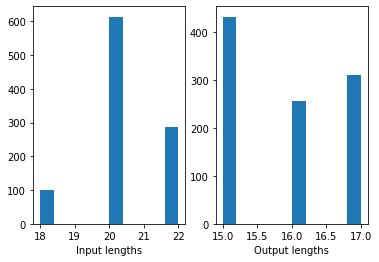

In [40]:
# Filter raw SCAN dataset and set toy parameters

# all_in_words = ['run', 'walk', 'look', 'jump', 'left', 'right', 'twice', 'opposite', 'thrice', 'turn', 'around', 'and', 'after']
# all_out_words = ['I_RUN', 'I_WALK', 'I_LOOK', 'I_JUMP', 'I_TURN_LEFT', 'I_TURN_RIGHT']

scan_params = {
  'in_words': ['run', 'walk', 'after', 'and',],
  'out_words': ['I_RUN', 'I_WALK', ],
  'extend_scan': True,
  'min_out_len': 15,
  'max_out_len': 20,
  'max_in_len': 25,
  'trials': 1000,
  'plot_lens': True,
  'periods': True,
}

# Reads in phrases from text_data and filters phrases to keep only those that have words in input_words
raw_in_phrases, raw_out_phrases = read_and_filter_scan(text_data, scan_params['in_words'])

max_in = max(list(map(len, raw_in_phrases)))
max_out = max(list(map(len, raw_out_phrases)))

print(f'Kept {len(raw_in_phrases)}/{len(text_data)} phrases. // Max in: {max_in} // Max out: {max_out} (pre-pad)')

scan_data, scan_params = generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=scan_params['trials'])
print('Input words:', scan_params['in_words'])
print('Output words:', scan_params['out_words'])

max_in = scan_data['inputs'].shape[1]
max_out = scan_data['labels'].shape[1]
print(f'Max in: {max_in} // Max out: {max_out} (post-pad)')

print('Scan input shape:', scan_data['inputs'].shape)
print('Scan labels shape:', scan_data['labels'].shape)
print('Scan indexs shape:', scan_data['index'].shape)

scan_params['plot_lens'] = False

# Sets toy parameters to match SCAN data so same code can be used below
toy_params = {
  'phrase_length': scan_params['max_in_len'],
  'var_length': True,
  'loss_type': 'XE',
  'in_words': scan_params['in_words'],
  'out_words': scan_params['out_words'],
  'scan_params': scan_params,
}

In [23]:
if run_tests:

  scan_params = {
    'in_words': ['run', 'walk', 'jump',],
    'out_words': ['I_RUN', 'I_WALK', 'I_JUMP', 'I_TURN_LEFT', 'I_TURN_RIGHT'],
    'extend_scan': True,
    'min_out_len': 10,
    'max_out_len': 20,
    'max_in_len': 31,
    'trials': 100,
    'plot_lens': True,
    'periods': False,
  }

  # Reads in phrases from text_data and filters phrases to keep only those that have words in input_words
  raw_in_phrases, raw_out_phrases = read_and_filter_scan(text_data, scan_params['in_words'])

  max_in = max(list(map(len, raw_in_phrases)))
  max_out = max(list(map(len, raw_out_phrases)))

  print(f'Kept {len(raw_in_phrases)}/{len(text_data)} phrases. // Max in: {max_in} // Max out: {max_out} (pre-pad)')

  scan_data, scan_params = generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=scan_params['trials'])

  max_in = scan_data['inputs'].shape[1]
  max_out = scan_data['labels'].shape[1]
  print('Total phrases:', scan_data['inputs'].shape[0], f'// Max in: {max_in} // Max out: {max_out} (post-pad)')

In [24]:
idx = 11
print('Input:', tensorToPhrase(scan_data['inputs'][idx], scan_params['in_words']))
print('Input tensor shape:', scan_data['inputs'][idx].shape)
print('Index:', scan_data['index'][idx])
print('Output:', tensorToPhrase(scan_data['labels'][idx], scan_params['out_words']))
print('Output tensor shape:', scan_data['labels'][idx].shape)

print('Input tensor:', scan_data['inputs'][idx][:10])
print('Label tensor:', scan_data['labels'][idx][:10])

Input: ['run', 'right', 'and', 'walk', 'left', '<.>', 'run', 'and', 'run', 'left', '<.>', 'run', 'and', 'run', 'left', '<.>', 'walk', 'right', 'and', 'walk', 'left', '<.>', '<pad>', '<pad>', '<pad>']
Input tensor shape: (25, 7)
Index: 19
Output: ['I_TURN_RIGHT', 'I_RUN', 'I_TURN_LEFT', 'I_WALK', '<.>', 'I_RUN', 'I_TURN_LEFT', 'I_RUN', '<.>', 'I_RUN', 'I_TURN_LEFT', 'I_RUN', '<.>', 'I_TURN_RIGHT', 'I_WALK', 'I_TURN_LEFT', 'I_WALK', '<.>', '<pad>', '<pad>']
Output tensor shape: (20, 6)
Input tensor: [[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
Label tensor: [[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]]


# Train and Build Network

In [25]:
def build_rnn(rnn_specs):
  """Builds a single layer RNN (Vanilla/GRU/LSTM/UGRNN with readout)"""

  vocab_size = rnn_specs['input_size']
  phrase_length = rnn_specs['phrase_length']

  if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att']: # Attention mechanisms double hidden size
    num_units = 2*rnn_specs['hidden_size']
    print('Doubling hidden units for attention.')
  else:
    num_units = rnn_specs['hidden_size']
  num_outputs = rnn_specs['output_size']

  def build_cell_rnn(units):
    if rnn_specs['cell_type'] == 'Vanilla':
      cell = renn.rnn.cells.VanillaRNN(units)
    elif rnn_specs['cell_type'] == 'GRU':
      cell = renn.rnn.cells.GRU(units)
    elif rnn_specs['cell_type'] == 'LSTM':
      cell = renn.rnn.cells.LSTM(units)
    elif rnn_specs['cell_type'] == 'UGRNN':
      cell = renn.rnn.cells.UGRNN(units)
    return cell

  def build_readout():
    if rnn_specs['ro_bias']:
      readout_init, readout_apply = stax.Dense(num_outputs)
    else:
      readout_init, readout_apply = Dense_nobias(num_outputs)
    return readout_init, readout_apply

  def build_attention():
    attention_init, attention_apply = attention(phrase_length)  
    return attention_init, attention_apply  

  def init_fun(prng_key, enc_input_shape, dec_input_shape):
    """Initializes the network (the embedding and the RNN cell)."""
    k0, k1, k2, k3 = jax.random.split(prng_key, 4)
    output_shape, rnn_params = cell.init(k0, enc_input_shape[1:])
    
    if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att']: # Readout size reduced by 1/2 since only uses first half of hidden
      output_shape = output_shape[:-1] + (int(1/2*output_shape[-1]),)
    elif rnn_specs['arch'] in ['enc_dec_atth']: # Readout size is doubled since concatanation of hidden and context
      output_shape = output_shape[:-1] + (int(2*output_shape[-1]),)

    # We explicitly add the batch dimension back in.
    # (This is because we only applied `vmap` to the rnn_apply function above)
    batch_output_shape = (enc_input_shape[0],) + output_shape

    _, readout_params = readout_init(k1, output_shape)
    if rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_atth']:
      _, rnn_params_dec = cell_dec.init(k2, dec_input_shape[1:])
      return batch_output_shape, (rnn_params, rnn_params_dec, readout_params)
    elif rnn_specs['arch'] in ['enc_dec_att',]:
      _, rnn_params_dec = cell_dec.init(k2, dec_input_shape[1:])
      _, att_params = attention_init(k3, (phrase_length,))
      return batch_output_shape, (rnn_params, rnn_params_dec, att_params, readout_params)
    else:
      return batch_output_shape, (rnn_params, readout_params)

  def apply_fun_one_to_one(params, inputs):
    """Applies the RNN in the usual way."""
    # Destructure parameter tuple.
    rnn_params, readout_params = params

    # [batch, len, dim]
    initial_states = cell.get_initial_state(rnn_params, batch_size=inputs.shape[0])

    batch_apply = functools.partial(cell.batch_apply, rnn_params)
    
    all_logits = renn.rnn.unroll.unroll_rnn(initial_states, inputs, batch_apply, functools.partial(readout_apply, readout_params))
    return all_logits

  def apply_fun_enc_dec(params, inputs):
    """Applies the RNN using encoder-decoder structure with different cells for both encoder and decoder"""
    # Destructure parameter tuple.
    rnn_params_enc, rnn_params_dec, readout_params = params

    # Only gets initial state from encoder, [batch, len, dim]
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])

    batch_apply_enc = functools.partial(cell.batch_apply, rnn_params_enc)
    batch_apply_dec = functools.partial(cell_dec.batch_apply, rnn_params_dec)

    rnn_apply = batch_apply_enc, batch_apply_dec
    
    all_logits = encode_decode(initial_states, inputs, rnn_apply, functools.partial(readout_apply, readout_params))
    return all_logits

  def apply_fun_enc_dec_att(params, inputs):
    """Applies the RNN using encoder-decoder structure with different cells for both encoder and decoder and with attention mechanism"""
    
    if rnn_specs['arch'] == 'enc_dec_short':
      rnn_params_enc, rnn_params_dec, readout_params = params
      # Builds attend matrix based on shorts
      att_params = jnp.diag(jnp.asarray([int(i in rnn_specs['shorts']) for i in range(phrase_length)]))
    elif rnn_specs['arch'] == 'enc_dec_att':
      rnn_params_enc, rnn_params_dec, att_params, readout_params = params
    elif rnn_specs['arch'] == 'enc_dec_atth':
      rnn_params_enc, rnn_params_dec, readout_params = params

    # Only gets initial state from encoder, [batch, len, dim]
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])

    batch_apply_enc = functools.partial(cell.batch_apply, rnn_params_enc)
    batch_apply_dec = functools.partial(cell_dec.batch_apply, rnn_params_dec)

    rnn_apply = batch_apply_enc, batch_apply_dec
    # Softmax across dimension multiplying encoder sequence

    if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att']:
      att_apply = functools.partial(attention_apply, jax.nn.softmax(att_params, axis=0))
      all_logits = encode_decode_attn(initial_states, inputs, rnn_apply, att_apply,
                                      functools.partial(readout_apply, readout_params), zero_context=rnn_specs['zero_context'])
    elif rnn_specs['arch'] in ['enc_dec_atth']:
      dec_seq_size = (inputs.shape[0], rnn_specs['out_len'], len(toy_params['out_words'])) # (batch size, phrase len, output word size)
      all_logits = encode_decode_attnh(initial_states, inputs, rnn_apply, functools.partial(readout_apply, readout_params), 
                                       zero_context=rnn_specs['zero_context'], variable_len=toy_params['var_length'],
                                       dec_seq_size=dec_seq_size, pos_enc=rnn_specs['pos_enc'])
    return all_logits

  def mask_fun(sequences, last_index):
    """Selects the last valid timestep from a batch of padded sequences."""
    # last_index.shape = (batch_size, phrase_length)
    last_index = last_index[:, :, jnp.newaxis]
    # sequences.shape = (batch_size, phrase_length, vocab_size)
    return jnp.take_along_axis(sequences, last_index, axis=1)

  def mask_sequences(sequences, last_index):
    """Set positions beyond the length of each sequence to 0. For sequences of shape (batch_size, seq_len, vocab_size)"""
    # sequences.shape = (batch_size, seq_length, vocab_size)
    # last_index.shape = (batch_size)
    mask = last_index[:, jnp.newaxis] >= jnp.arange(sequences.shape[1])
    return sequences * jnp.repeat(mask[:,:,jnp.newaxis], sequences.shape[-1], axis=2)

  def mask_sequences_one(sequences, last_index):
    """Set positions beyond the length of each sequence to 0. For sequences of shape (batch_size, seq_len)"""
    # sequences.shape = (batch_size, seq_length)
    # last_index.shape = (batch_size)
    mask = last_index[:, jnp.newaxis] >= jnp.arange(sequences.shape[1])
    return sequences * mask

  def sigmoid_xent_with_logits(logits, labels):
    return jnp.maximum(logits, 0) - logits * labels + \
        jnp.log(1 + jnp.exp(-jnp.abs(logits)))

  def xe_loss_fn(logits, labels, lengths):
    """
    Contains both log softmax and negative log liklihood loss
    """
    # Shifts maximum to zero
    shifted = logits - jax.lax.stop_gradient(logits.max(axis=-1, keepdims=True))
    log_probs = shifted - jnp.log(jnp.sum(jnp.exp(shifted), axis=-1, keepdims=True))

    labels_max = jnp.argmax(labels, axis=2)
    
    logliklihood = jnp.take_along_axis(log_probs, jnp.expand_dims(labels_max, axis=2), axis=2)

    xe_loss = -1 * np.mean(mask_sequences_one(jnp.squeeze(logliklihood), lengths))

    return xe_loss

  def loss_fun(params, batch):
    """Cross-entropy loss function."""
    all_logits = apply_fun(params, batch['inputs'])
    # logits = mask_sequences(all_logits, batch['index'])
    # labels = mask_sequences(batch['labels'], batch['index'])
    flatten = lambda params: jax.flatten_util.ravel_pytree(params)[0]
    l2_loss = train_params['l2reg'] * np.sum(flatten(params)**2)
    
    # xe_loss = xe_loss_fn(logits, labels)
    xe_loss = xe_loss_fn(all_logits, batch['labels'], batch['index'])

    loss = l2_loss + xe_loss
    # Average over the batch
    return loss

  @jax.jit
  def accuracy_fun(params, batch):
    all_logits = apply_fun(params, batch['inputs'])

    logits = mask_sequences(all_logits, batch['index'])
    labels = mask_sequences(batch['labels'], batch['index'])
    
    predictions = jnp.argmax(logits, axis=2).astype(jnp.int32)
    labels_max = jnp.argmax(labels, axis=2).astype(jnp.int32)
    # Entire output phrase must match target to count
    return np.all(labels_max == predictions, axis=1)

  # Build the RNN cell.
  cell = build_cell_rnn(num_units)
  readout_init, readout_apply = build_readout()
  
  if rnn_specs['arch'] == 'enc_dec':
    cell_dec = build_cell_rnn(num_units) # decoder cell
    apply_fun = apply_fun_enc_dec
  elif rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att']:
    cell_dec = build_cell_rnn(num_units) # decoder cell can take shorted input now
    attention_init, attention_apply = build_attention() # Uses attention with fixed shorts or learnable parameters
    apply_fun = apply_fun_enc_dec_att
  elif rnn_specs['arch'] in ['enc_dec_atth']:
    cell_dec = build_cell_rnn(num_units) # decoder cell can take shorted input now
    apply_fun = apply_fun_enc_dec_att
  elif rnn_specs['arch'] == 'enc_dec_one':
    apply_fun = apply_fun_enc_dec_one
  elif rnn_specs['arch'] == 'one_to_one':
    apply_fun = apply_fun_one_to_one
  else:
    raise ValueError('Rnn arch not recognized.')
    
  return init_fun, apply_fun, mask_sequences, loss_fun, accuracy_fun

def build_optimizer_step(optimizer, initial_params, loss_fun, gradient_clip=None):
  """Builds training step function."""

  # Destructure the optimizer triple.
  init_opt, update_opt, get_params = optimizer
  opt_state = init_opt(initial_params)

  @jax.jit
  def optimizer_step_noclip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss

  @jax.jit
  def optimizer_step_clip(current_step, state, batch):
    """Takes a single optimization step with clipped gradients."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun)(p, batch)
    
    gradients = optimizers.clip_grads(gradients, gradient_clip)

    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss    
  
  if gradient_clip is None:
    return opt_state, optimizer_step_noclip
  else:
    return opt_state, optimizer_step_clip

def Dense_nobias(out_dim, W_init=jax.nn.initializers.glorot_normal()):
  """Layer constructor function for a dense (fully-connected) layer without bias."""
  def init_fun(rng, input_shape):
    # input shape = (seq_length, hidden_dims)
    # output shape = (seq_length, out_dim)
    output_shape = input_shape[:-1] + (out_dim,)
    k1, _ = jax.random.split(rng)
    W = W_init(k1, (input_shape[-1], out_dim))
    return output_shape, (W)
  def apply_fun(params, inputs, **kwargs):
    W = params
    return jnp.dot(inputs, W)
  return init_fun, apply_fun

def attention(out_dim, W_init=jax.nn.initializers.glorot_normal()):
  """Layer constructor function for a attention matrix."""
  def init_fun(rng, input_shape):
    # input shape = (# encoders,)
    # output shape = (# decoders,)
    output_shape = (out_dim,)
    k1, _ = jax.random.split(rng)
    att_mat = W_init(k1, (input_shape[0], out_dim))
    return output_shape, (att_mat)
  def apply_fun(params, inputs, **kwargs):
    att_mat = params
    return jnp.dot(inputs, att_mat)
  return init_fun, apply_fun

#### Synthetic/SCAN Training Functions

In [26]:
# Synthetic/scan data functions

def generate_data(dataset_size, toy_params, rnn_specs):
  """
  Generate training data in numpy and then converts to JAX arrays
  """

  out_size = rnn_specs['output_size']

  syn_out_phrases = []
  syn_in_phrases = []
  syn_targets_np = np.zeros((dataset_size, toy_params['phrase_length'], out_size))
  syn_inputs_np = np.zeros((dataset_size, toy_params['phrase_length'], len(toy_params['in_words'])))
  # syn_target_masks_np = []
  syn_target_masks_np = np.zeros((dataset_size,))

  start_time = time.time()
  for trial in range(dataset_size):
    sentiment, phrase, sentiment_tensor, phrase_tensor, target_mask = randomTrainingExample(toy_params)
    
    syn_targets_np[trial, :, :] = sentiment_tensor
    syn_inputs_np[trial, :, :] = phrase_tensor
    syn_target_masks_np[trial] = target_mask
    # syn_target_masks_np.append(target_mask)

  print('Sythentic data generated in: {:0.2f} sec.'.format(time.time() - start_time))

  # Converts to JAX arrays
  syn_targets = jnp.asarray(syn_targets_np)
  syn_inputs = jnp.asarray(syn_inputs_np)  
  syn_target_masks = jnp.asarray(syn_target_masks_np, dtype=jnp.int32)
  # syn_target_masks =  syn_target_masks_np

  syn_data = {
    'inputs': syn_inputs,  # Phrase tensors: dataset_size x phrase_len x in_dim
    'labels': syn_targets, # Sentiment tensors: dataset_size x phrase_len x out_dim
    'index': syn_target_masks, # Target mask: list of integers up to phrase_len
  }

  return syn_data

def shuffle_data(syn_data):
  """ Shuffles synthetic data for different epochs """
  dataset_size = syn_data['inputs'].shape[0]
  shuf_idxs = np.asarray(range(dataset_size), dtype=jnp.int32)
  np.random.shuffle(shuf_idxs)

  syn_data['inputs'] = syn_data['inputs'][shuf_idxs]
  syn_data['labels'] = syn_data['labels'][shuf_idxs]

  return syn_data

def override_data(path, save_file):
  if save_file and os.path.exists(path):
    print('File already exists at:', path)
    override = input('Override? (Y/N):')
    if override == 'Y':
      save_file = True
    else:
      save_file = False

  return save_file

def save_run_data(path, save_file, params_jax, toy_params, rnn_specs, train_params):

  if save_file:
    # # Converts into numpy arrays
    # params_onp = {}
    # for param_key in params_jax:
    #   params_onp[param_key] = np.asarray(params_jax[param_key])

    with open(path, 'wb') as save_file:
        pickle.dump(params_jax, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(toy_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(rnn_specs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(train_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)

    print('Data Saved')
  else:
    print('Data Not Saved')

def test_accuracy(params, test_batch):
  _accs = accuracy_fun(params, test_batch)

  return np.mean(_accs)

def train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs):
  """ Generate sythetic and test data and train for some number of epochs"""
  
  train_set_size = train_params['train_set_size']
  test_set_size = train_params['test_set_size']
  num_batchs = train_params['num_batchs']
  global_step = train_params['global_step']
  total_steps = train_params['total_steps']
  train_losses = train_params['train_losses']
  decay_fun = train_params['decay_fun']
  print_every = train_params['print_every']
  batch_size = train_params['batch_size']

  for dataset in range(train_params['n_datasets']):
    # Generates new train/test datasets 
    syn_data = generate_data(train_set_size, toy_params, rnn_specs)
    syn_data_test = generate_data(test_set_size, toy_params, rnn_specs)

    # Sets output sequence length to length of output sequence
    rnn_specs['out_len'] = syn_data['labels'].shape[1]

    for epoch in range(train_params['epochs']):
      # Shuffles training data after first epoch
      if epoch > 0:
        print('Shuffling Data')
        syn_data = shuffle_data(syn_data)

      print('Running batches {} to {}'.format(global_step, global_step+num_batchs))
      start_time = time.time()  
      avg_loss = 0 
      for step in range(total_steps, total_steps+num_batchs):
        batch = step - total_steps 
        batch_data = {
          'inputs': syn_data['inputs'][batch*batch_size:(batch+1)*batch_size, :, :], # Phrase tensors: batch x phrase_len x in_dim
          'labels': syn_data['labels'][batch*batch_size:(batch+1)*batch_size, :, :], # Sentiment tensors: batch x phrase_len x out_dim
          'index': syn_data['index'][batch*batch_size:(batch+1)*batch_size], # Target mask: list of integers up to phrase_len
        }

        global_step, opt_state, loss = step_fun(global_step, opt_state, batch_data)
        train_losses.append(loss)
        avg_loss += loss

        if (global_step+1) % print_every == 0:
          test_acc = test_accuracy(get_params(opt_state), syn_data_test)

          batch_time = time.time() - start_time
          step_size = decay_fun(global_step)
          s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
          print(s.format(global_step+1, batch_time, step_size, test_acc, avg_loss/print_every))
          start_time = time.time()
          avg_loss = 0

      train_params['total_steps'] += num_batchs
  
  train_params['global_step'] = global_step
  train_params['train_losses'] = train_losses

  return opt_state, train_params

def train_on_scan_data(scan_data, opt_state, train_params, toy_params, rnn_specs):
  """ Train SCAN data (imported elsewhere) for some number of epochs"""
  
  train_set_size = train_params['train_set_size']
  test_set_size = train_params['test_set_size']
  global_step = train_params['global_step']
  total_steps = train_params['total_steps']
  train_losses = train_params['train_losses']
  decay_fun = train_params['decay_fun']
  print_every = train_params['print_every']
  batch_size = train_params['batch_size']

  scan_params = toy_params['scan_params']
  
  for dataset in range(train_params['n_datasets']):
    # Generate scan data (normal or extended, for latter doesn't use trial count)
    scan_data, scan_params = generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=train_params['train_set_size'])
    
    # max_in = scan_data['inputs'].shape[1]
    # max_out = scan_data['labels'].shape[1]
    # print(f'Max in: {max_in} // Max out: {max_out} (post-pad)')

    # print('Scan input shape:', scan_data['inputs'].shape)
    # print('Scan labels shape:', scan_data['labels'].shape)
    # print('Scan indexs shape:', scan_data['index'].shape)
    
    if scan_params['extend_scan']:  # Generates new test set for extended scan
      scan_test_data, scan_params = generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=train_params['test_set_size'])
      num_batchs = train_params['num_batchs']
    else:
      # Handles incomplete batches
      num_batchs = int(np.floor(scan_data['inputs'].shape[0]/batch_size))
      print(f'Running {num_batchs} batches per epoch.')
      # For now, just uses full SCAN set as test set when not extending
      scan_test_data = scan_data
    # Sets output sequence length to length of output sequence
    rnn_specs['out_len'] = scan_test_data['labels'].shape[1]

    for epoch in range(train_params['epochs']):
      # Shuffles training data after first epoch
      if epoch > 0:
        scan_data = shuffle_data(scan_data)

      start_time = time.time()  
      avg_loss = 0 
      for step in range(total_steps, total_steps+num_batchs):
        batch = step - total_steps 
        batch_data = {
          'inputs': scan_data['inputs'][batch*batch_size:(batch+1)*batch_size, :, :], # Phrase tensors: batch x phrase_len x in_dim
          'labels': scan_data['labels'][batch*batch_size:(batch+1)*batch_size, :, :], # Sentiment tensors: batch x phrase_len x out_dim
          'index': scan_data['index'][batch*batch_size:(batch+1)*batch_size], # Target mask: list of integers up to phrase_len
        }

        global_step, opt_state, loss = step_fun(global_step, opt_state, batch_data)
        train_losses.append(loss)
        avg_loss += loss

        if (global_step+1) % print_every == 0:
          test_acc = test_accuracy(get_params(opt_state), scan_test_data)

          batch_time = time.time() - start_time
          step_size = decay_fun(global_step)
          s = "Step {} in {:0.2f} sec, step size: {:0.5f}, test acc {:0.4f}, avg training loss {:0.4f}"
          print(s.format(global_step+1, batch_time, step_size, test_acc, avg_loss/print_every))
          start_time = time.time()
          avg_loss = 0

      train_params['total_steps'] += num_batchs
  
  train_params['global_step'] = global_step
  train_params['train_losses'] = train_losses

  return opt_state, train_params

def default_params(train_params, toy_params, rnn_specs):
  """ Sets the defaults of many parameters if not specified"""

  if 'cell_type' not in rnn_specs: rnn_specs['cell_type'] = 'GRU'
  if 'zero_context' not in rnn_specs: rnn_specs['zero_context'] = False

  return train_params, toy_params, rnn_specs

#### Architecture Tests

In [27]:
#### Functions for encoder->decoder structure

def identity(x):
  """Identity function f(x) = x."""
  return x

def encode_decode(initial_states, input_sequences, rnn_update, readout=identity, return_hidden=False):

  def _step_e(state, inputs):
    """ Encoder step, output is simply hidden states """

    next_state = enc_update(inputs, state)
    outputs = identity(next_state)
    return next_state, outputs

  def _step_d(carry, null_inputs):
    """ Decoder step, output goes through readouts now """
    state, inputs = carry

    next_state = dec_update(inputs, state)
    outputs = readout(next_state)
    
    # Convers outputs into one-hot vectors to pass back into network
    output_tensors = jax.nn.one_hot(jnp.argmax(outputs, axis=1), outputs.shape[1])
    carry = next_state, output_tensors
    
    if not return_hidden:
      return carry, outputs
    else:
      return carry, next_state

  enc_update, dec_update = rnn_update

  # Run encoder
  input_sequences = jnp.swapaxes(input_sequences, 0, 1)
  encode_final, enc_outs = jax.lax.scan(_step_e, initial_states, input_sequences)

  eos_input = jnp.zeros(input_sequences[0].shape)
  init_val = (encode_final, eos_input)

  # Run decoder
  input_seq_null = jnp.zeros(input_sequences.shape) # These inputs aren't used
  _, dec_outs = jax.lax.scan(_step_d, init_val, input_seq_null)

  if not return_hidden:
    return jnp.swapaxes(dec_outs, 0, 1)
  else:
    full_hs = jnp.concatenate((enc_outs, dec_outs), axis=0)
    return jnp.swapaxes(full_hs, 0, 1)

def encode_decode_attn(initial_states, input_sequences, rnn_update, attention_apply, readout=identity,
                       return_hidden=False, zero_context=False):
  """ 
  Encoder decoder structure which implements attention using a learnable attention layer. This 
  attention layer passes a context to the INPUT of the RNN by concatenating it with the hidden state.
  """

  hidden_state_keep = int(1/2*initial_states.shape[-1])
  # print('Keeping first {} of {} hidden'.format(hidden_state_keep, initial_states.shape[-1]))

  def _step_e(state, inputs):
    """ Encoder step, output is simply hidden states 
    state = (batch_size, 2*hidden_size)
    inputs = (batch_size, input_size)
    """
    if zero_context:
      state = jnp.zeros(state.shape)
    # Zeros second half of the hidden state
    state = jnp.concatenate([state[:,:hidden_state_keep], jnp.zeros((state.shape[0], hidden_state_keep))], axis=1)

    next_state = enc_update(inputs, state)
    outputs = identity(next_state[:,:hidden_state_keep])
    return next_state, outputs

  def _step_d(carry, seq_input):
    """ Decoder step, output goes through readouts now """
    state, inputs = carry # unpack carry
    if zero_context:
      print('Zeroing Context')
      state = jnp.zeros(state.shape)
    # Concatanate seq_input with hidden to get new hidden (for attention)
    state = jnp.concatenate([state[:,:hidden_state_keep], seq_input], axis=1)

    next_state = dec_update(inputs, state)
    # Only first half of hidden state goes to readout
    outputs = readout(next_state[:,:hidden_state_keep])
    
    # Converts outputs into one-hot vectors to pass back into network
    output_tensors = jax.nn.one_hot(jnp.argmax(outputs, axis=1), outputs.shape[1])
    carry = next_state, output_tensors
    
    if not return_hidden:
      return carry, outputs
    else:
      return carry, next_state[:,:hidden_state_keep]

  enc_update, dec_update = rnn_update

  # Run encoder
  input_sequences = jnp.swapaxes(input_sequences, 0, 1)
  encode_final, enc_outs = jax.lax.scan(_step_e, initial_states, input_sequences)

  eos_input = jnp.zeros(input_sequences[0].shape)
  init_val = (encode_final, eos_input)

  # Run decoder
  input_seq_hidden = enc_outs # Hidden states of encoder (enc_seq_len, batch_size, hidden_size)

  # Multiplies hidden states by the attend matrix (with some swap axes to get everything the right shape)
  input_seq = jnp.swapaxes(attention_apply(jnp.swapaxes(input_seq_hidden, 0, 2)), 0, 2)

  _, dec_outs = jax.lax.scan(_step_d, init_val, input_seq)

  if not return_hidden:
    return jnp.swapaxes(dec_outs, 0, 1)
  else:
    full_hs = jnp.concatenate((enc_outs, dec_outs), axis=0)
    return jnp.swapaxes(full_hs, 0, 1)

def encode_decode_attnh(initial_states, input_sequences, rnn_update, readout=identity,
                        return_hidden=False, zero_context=False, variable_len=False, dec_seq_size=None, pos_enc='standard'):
  """ 
  Encoder decoder structure with attention, this time using the hidden state overlap to find attention.
  Here the attention context vector gets concatenated with the decoder RNN output and passed to the readout.
  
  input_sequence: shape (batch_size, in_seq_len, input_dim)
  dec_seq_size: (batch_size, out_seq_len, input_dim)
  
  """

  if variable_len:
    eos_idx = toy_params['in_words'].index('<pad>')
    print('eos_idx', eos_idx)
    # input_sequences.shape[-1] - 1 # assumes eos is last word in vocab

  def _step_e(carry, inputs):
    """ Encoder step, output is simply hidden states 
    state = (batch_size, 2*hidden_size)
    seq_input = (batch_size, input_size)
    """
    old_state, is_eos = carry
    seq_input, pos_enc_vals = inputs

    if zero_context:
      next_state = enc_update(seq_input + pos_enc_vals, jnp.zeros(old_state.shape))
    else:
      next_state = enc_update(seq_input + pos_enc_vals, old_state)
    # determines which state to carry to next input 
    carried_state = jnp.where(is_eos[:, np.newaxis], old_state, next_state)
    outputs = identity(carried_state)
    
    # Update is_eos (true if one-hot in eos_idx)
    if variable_len:
      is_eos = jnp.logical_or(is_eos, seq_input[:, eos_idx])
    
    return (carried_state, is_eos), outputs

  def _step_d(carry, seq_input):
    """ Decoder step, output goes through readouts now """
    state, inputs = carry # unpack carry into hidden sate and previous input

    # Adds seq_input to carried inputs (seq_input is just zeros unless using positional encoding)
    inputs = inputs + seq_input

    if zero_context:
      next_state = dec_update(inputs, jnp.zeros(state.shape))
    else:
      next_state = dec_update(inputs, state)

    # Uses the output of the decoder to calculate the attention state (can normalize by sqrt(hidden_size), similar to transformers)
    # (batch, hidden) x (seq_len, batch, hidden) -> (seq_len, batch)
    attention_row = jax.nn.softmax(jnp.einsum('ij,kij->ki', next_state, input_seq_hidden), axis=0)
    # attention_row = jax.nn.softmax(jnp.einsum('ij,kij->ki', next_state, input_seq_hidden)/np.sqrt(next_state.shape[1]), axis=0)
    # (seq_len, batch) x (seq_len, batch, hidden) -> (batch, hidden)
    attention_state = jnp.einsum('ij,ijk->jk', attention_row, input_seq_hidden)

    # Concatenated first half of hidden state and attention state go to readout
    outputs = readout(jnp.concatenate([next_state, attention_state], axis=1))
    
    # Converts outputs into one-hot vectors to pass back into network
    output_tensors = jax.nn.one_hot(jnp.argmax(outputs, axis=1), outputs.shape[1])
    carry = next_state, output_tensors
    
    if not return_hidden:
      return carry, outputs
    else:
      return carry, next_state

  enc_update, dec_update = rnn_update
  # Run encoder
  is_eos = jnp.zeros(input_sequences.shape[0], dtype=np.bool) # (batch_size)
  initial_carry = (initial_states, is_eos)
  if pos_enc == 'standard':
    amp = 1.0
    pos_enc_scale = 20 #/(2*np.pi)
    print(f'Adding pos_enc to encoder. \\ Amp: {amp} \\ Time Scale: {pos_enc_scale}')
    pos_enc_vals = positional_encoding(input_sequences, scale=pos_enc_scale, amp=amp)  
  else:
    pos_enc_vals = jnp.zeros(input_sequences.shape)
  pos_enc_vals = jnp.swapaxes(pos_enc_vals, 0, 1)
  input_sequences = jnp.swapaxes(input_sequences, 0, 1)
  # Keeps inputs and potential positional encoding values separate so EoS character still identifiable
  encode_final, enc_outs = jax.lax.scan(_step_e, initial_carry, (input_sequences, pos_enc_vals))

  encode_final_hs, _ = encode_final
  if dec_seq_size == None: # Assumes same dimension of output sequence as input sequence if left blank
    dec_seq_size = input_sequences.shape[:-1] + (rnn_specs['output_size'],)
  eos_input = jnp.zeros((dec_seq_size[0], dec_seq_size[2])) # shape: (batch_size, decoder input dim)
  init_val = (encode_final_hs, eos_input)

  input_seq_hidden = enc_outs # Hidden states of encoder (used for attention) (enc_seq_len, batch_size, hidden_size)
  
  # Run decoder
  dec_seq_null = jnp.zeros(dec_seq_size) # These inputs aren't used
  if pos_enc == 'standard':
    print(f'Adding pos_enc to decoder. \\ Amp: {amp} \\ Time Scale: {pos_enc_scale}')
    dec_seq_null = dec_seq_null + positional_encoding(dec_seq_null, scale=pos_enc_scale, amp=amp)  
  dec_seq_null = jnp.swapaxes(dec_seq_null, 0, 1)
  _, dec_outs = jax.lax.scan(_step_d, init_val, dec_seq_null)

  if not return_hidden:
    return jnp.swapaxes(dec_outs, 0, 1)
  else:
    full_hs = jnp.concatenate((enc_outs, dec_outs), axis=0)
    return jnp.swapaxes(full_hs, 0, 1)

def positional_encoding(seq, scale=50, amp=1.0):
  """ 
  Returns positional encoding values. 
  Assumes seq dimensions are (batch, seq_len, word_space) 
  """
  pos_enc = np.zeros(seq.shape[1:])
  word_dim = seq.shape[2]

  for word_idx in range(word_dim):
    if word_idx % 2 == 0:
      pos_enc[:, word_idx] = [amp*np.sin(seq_idx/(scale**(word_idx/word_dim))) for seq_idx in range(seq.shape[1])]
    else:
      pos_enc[:, word_idx] = [amp*np.cos(seq_idx/(scale**((word_idx - 1)/word_dim))) for seq_idx in range(seq.shape[1])]

  return np.repeat(pos_enc[np.newaxis, :, :], seq.shape[0], axis=0)

In [28]:
run_tests = True

if run_tests:

  seed = 342343
  prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

  data_type = 'scan'

  ########## Toy data parameters ##########
  if data_type == 'toy':
    toy_params = {
      'phrase_length': 5,
      'base_words': 3,
      'var_length': False,
      'min_phrase_len': 2,
      'loss_type': 'XE',
      'rules': [None,] # prev0
    }

    toy_params['in_words'], toy_params['phrase_words'] = generateInputWordBank(toy_params)
    toy_params['out_words'], toy_params['translations'] = generateOutputWordBank(toy_params)

  ########## RNN hyperparameters ##########
  rnn_specs = {
    'cell_type': 'GRU',                              # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
    'arch': 'enc_dec_atth',                          # Type of architecture
    'pos_enc': 'standard',                           # Positional encoding: 'standard', 'hidden_conc'
    'shorts': (),
    'zero_context': False,
    'input_size': len(toy_params['in_words']),       # Number of inputs to the RNN
    'hidden_size': 128,                              # Number of units in the RNN
    'output_size': len(toy_params['out_words']),     # Number of outputs in the RNN
    'ro_bias': True,                                 # Include a bias with the readout
    'ro_simplex_init': False,
    'phrase_length': toy_params['phrase_length']     # Needed to build the attention matrix
  }

  ########## Train hyperparameters ##########

  train_params = {
    'batch_size': 2,                     # How many examples in each batch
    'num_batchs': 1,                    # Total number of batches to train on.
  }

  train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 

  # Generate the data to run through the RNN
  if data_type == 'toy':
    syn_data = generate_data(train_params['train_set_size'], toy_params, rnn_specs)
  else:
    syn_data, _ = generate_scan(raw_in_phrases, raw_out_phrases, toy_params['scan_params'], trials=train_params['train_set_size'])
  
  rnn_specs['out_len'] = syn_data['labels'].shape[1]

  print('Vocab:', toy_params['in_words'])
  print('Sythetic lengths:', syn_data['index'])

  # Initialize the optimizer.
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  enc_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['in_words']))
  dec_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['out_words']))
  output_shape, initial_params = init_fun(prng_key, enc_input_shape, dec_input_shape)

  if rnn_specs['arch'] == 'enc_dec_att':
    rnn_params, rnn_params_dec, att_params, readout_params = initial_params
  elif rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_atth']:
    rnn_params, rnn_params_dec, readout_params = initial_params
  else:
    rnn_params, readout_params = initial_params

  # cell = build_cell(rnn_specs)
  out_logits = apply_fun(initial_params, syn_data['inputs'])

  print('Output logits shape:', out_logits.shape)
  print('Output logits:', out_logits)
  # print('Output logits:', out_logits[0, :5, :2])
  # print('Output logits:', out_logits[1, :5, :2])
  print('Output labels:', syn_data['labels'])

SCAN data generated in: 0.00 sec.
Vocab: ['run', 'walk', 'left', 'right', 'and', '<.>', '<pad>']
Sythetic lengths: [20 17]
eos_idx 6
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 20
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 20
Output logits shape: (2, 20, 6)
Output logits: [[[-0.05731487  0.02100943  0.03972166 -0.19318466 -0.05218885
   -0.07825763]
  [-0.01753899 -0.1704824   0.02997885 -0.3343095  -0.13020065
   -0.07934161]
  [ 0.01004151 -0.3369534   0.07633116 -0.35539553 -0.18578815
   -0.05214558]
  [ 0.00083878 -0.38116807  0.13698131 -0.3365519  -0.21795858
   -0.0191207 ]
  [-0.03619695 -0.3124017   0.18778318 -0.3417947  -0.2226474
   -0.04878919]
  [-0.07435    -0.22523493  0.21797162 -0.38791814 -0.22042955
   -0.13828695]
  [-0.07922013 -0.21125613  0.24529299 -0.42498162 -0.2337946
   -0.20632619]
  [-0.0470608  -0.2783414   0.2959557  -0.39319938 -0.25209448
   -0.19465348]
  [-0.01694734 -0.36366558  0.35977027 -0.28753346 -0.26070225
   -0.09951886]
 

First time step: [0. 1. 0. 1. 0. 1. 0.]


Text(0, 0.5, 'Sequence Index')

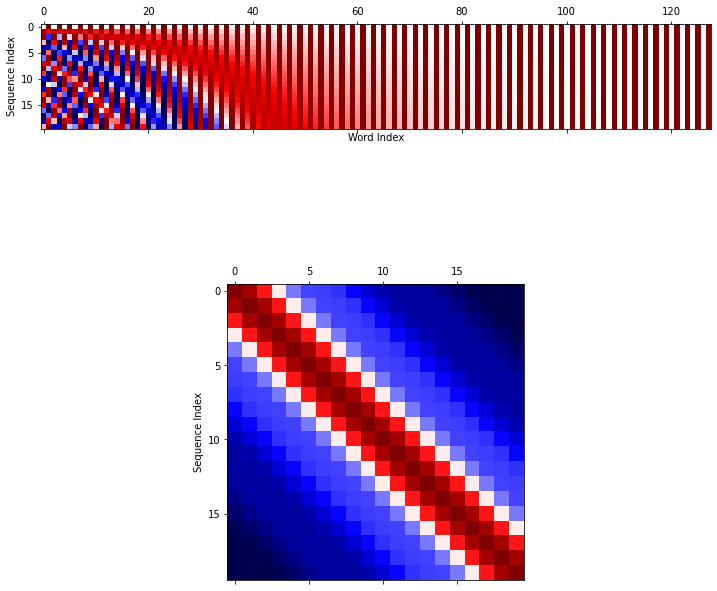

In [29]:
seq_len_test = 20
word_dims = 128
test_seq = np.zeros((5, seq_len_test, word_dims))

pos_enc = positional_encoding(test_seq, scale=10000)

print('First time step:', pos_enc[0,0,:7])

pos_enc_dots = np.zeros((seq_len_test, seq_len_test))
for i in range(seq_len_test):
  for j in range(seq_len_test):
    pos_enc_dots[i,j] = np.dot(pos_enc[0,i], pos_enc[0,j])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.matshow(pos_enc[0], cmap=plt.cm.seismic)
ax2.matshow(pos_enc_dots, cmap=plt.cm.seismic)

ax1.set_ylabel('Sequence Index')
ax1.set_xlabel('Word Index')

ax2.set_ylabel('Sequence Index')
ax2.set_ylabel('Sequence Index')

(3, 20)


Text(0, 0.5, 'PC2')

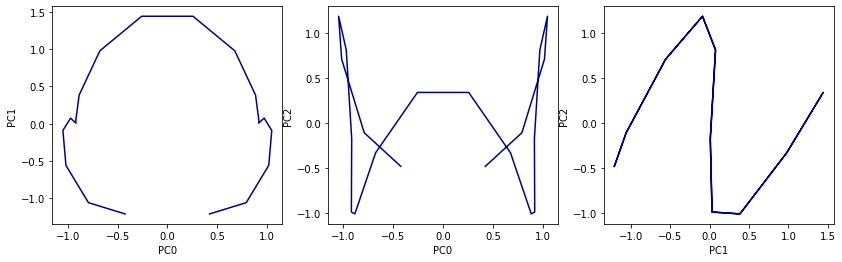

In [30]:
seq_len_test = 20
word_dims = 6
test_seq = np.zeros((1, seq_len_test, word_dims))

amp = 1.0
pos_enc_scale = 20

pos_enc = positional_encoding(test_seq, scale=pos_enc_scale, amp=amp)

pca_time = PCA(n_components=3)
pca_pe = pca_time.fit_transform(pos_enc[0]).T
print(pca_pe.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))
ax1.plot(pca_pe[0], pca_pe[1], color='darkblue')
ax2.plot(pca_pe[0], pca_pe[2], color='darkblue')
ax3.plot(pca_pe[1], pca_pe[2], color='darkblue')
# ax1.plot(pos_enc[0, :, 0], pos_enc[0, :, 1], color='darkblue')
# ax1.plot(pos_enc[0, :, 2], pos_enc[0, :, 3], color='darkred')
# ax1.plot(pos_enc[0, :, 4], pos_enc[0, :, 5], color='darkgreen')
# ax2.plot(pos_enc[0, :, 0], pos_enc[0, :, 2], color='darkblue')
# ax3.plot(pos_enc[0, :, 2], pos_enc[0, :, 4], color='darkblue')
ax1.set_xlabel('PC0')
ax1.set_ylabel('PC1')
ax2.set_xlabel('PC0')
ax2.set_ylabel('PC2')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')

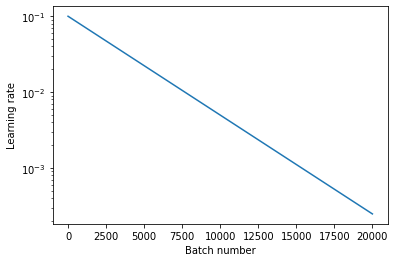

In [31]:
# Optimization hyperparameters
num_batchs = 20000        # Total number of batches to train on.
init_lr = 0.1          # initial learning rate
decay_factor = 0.9997     # decay the learning rate this much

learning_rate = optimizers.exponential_decay(init_lr, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = np.linspace(1, num_batchs)
plt.semilogy(batch_idxs, [learning_rate(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

#### Train the Network

In [42]:
seed = 342343
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

data_type = 'scan' # toy or scan

if data_type == 'toy':
  ########## Toy data parameters ##########
  toy_params = {
    'phrase_length': 20,    # INPUT phrase length (output phrase length could be different)
    'base_words': 5,
    'var_length': True,
    'min_phrase_len': 15,
    'loss_type': 'XE',
    'rules': [] # prev0
  }

  toy_params['in_words'], toy_params['phrase_words'] = generateInputWordBank(toy_params)
  toy_params['out_words'], toy_params['translations'] = generateOutputWordBank(toy_params)

########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'GRU',                              # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
  'arch': 'enc_dec_atth',                  # Architecture, supports 'one_to_one', 'enc_dec', 'enc_dec_short', 'enc_dec_att',
                                          # 'enc_dec_atth'
  'pos_enc': None, #'standard',                            # Positional encoding: 'standard', 'hidden_conc'
  'shorts': (),
  'zero_context': False,
  'input_size': len(toy_params['in_words']),       # Number of inputs to the RNN
  'hidden_size': 128,                              # Number of units in the RNN
  'output_size': len(toy_params['out_words']),     # Number of outputs in the RNN
  'ro_bias': False,                                # Include a bias with the readout
  'phrase_length': toy_params['phrase_length']     # Needed to build the attention matrix
}

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'l2reg': 0.0, #1e-6,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 1000,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'n_datasets': 6,                           # Number of new train sets to generate total (this is slow)
  'epochs': 2,                               # How many times to go through each train set completely
  'test_set_size': 200,
}

train_params['decay_fun'] = optimizers.exponential_decay(train_params['init_lr'], decay_steps=1, 
                                                         decay_rate=train_params['decay_factor'])
train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 
# Sets default parameters if they weren't set above
train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

########## Run ##########

print('# Input words:', len(toy_params['in_words']), 'Input words:', toy_params['in_words'])
print('# Output words:', len(toy_params['out_words']), 'Output words:', toy_params['out_words'])
print('Architecture:', rnn_specs['arch'])

new_network = True
load_network = False
save_data = False

path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_4classrgb_01-12-23-30is01_RObias_l2is5e-3.pickle'
save_data = override_data(path, save_data)

if new_network:
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  enc_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['in_words']))
  dec_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['out_words']))
  output_shape, initial_params = init_fun(prng_key, enc_input_shape, dec_input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

elif load_network:
 
  initial_params = params_loaded_jax
  output_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['out_words']))

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = train_params['train_losses'] if 'train_losses' in train_params else []
  train_params['global_step'] = train_params['total_steps']

else:
  train_params['train_losses'] = []
  train_params['total_steps'] = 12000
  train_params['global_step'] = train_params['total_steps']

# Generate synthetic data and run training on said data
if data_type == 'toy':
  opt_state, train_params = train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs)
elif data_type == 'scan':
  opt_state, train_params = train_on_scan_data(scan_data, opt_state, train_params, toy_params, rnn_specs)

train_params.pop('decay_fun') # Can't pickle with decay fun
save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

# Destructure the trained parameters of the RNN.
final_params = get_params(opt_state)
if rnn_specs['arch'] == 'enc_dec_att':
  rnn_params, rnn_params_dec, att_params, readout_params = final_params
elif rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_atth']:
  rnn_params, rnn_params_dec, readout_params = final_params
else:
  rnn_params, readout_params = final_params

# Input words: 6 Input words: ['run', 'walk', 'after', 'and', '<.>', '<pad>']
# Output words: 4 Output words: ['I_RUN', 'I_WALK', '<.>', '<pad>']
Architecture: enc_dec_atth
SCAN data generated in: 6.53 sec.
SCAN data generated in: 0.02 sec.
eos_idx 5
eos_idx 5
eos_idx 5
Step 100 in 10.72 sec, step size: 0.09707, test acc 0.0000, avg training loss 1.1012
Step 200 in 2.22 sec, step size: 0.09420, test acc 0.0000, avg training loss 0.9740
Step 300 in 2.19 sec, step size: 0.09142, test acc 0.0000, avg training loss 0.8847
Step 400 in 2.13 sec, step size: 0.08872, test acc 0.0000, avg training loss 0.9172
Step 500 in 2.19 sec, step size: 0.08610, test acc 0.0000, avg training loss 0.9319
Step 600 in 2.11 sec, step size: 0.08355, test acc 0.0000, avg training loss 0.7786
Step 700 in 2.14 sec, step size: 0.08108, test acc 0.0400, avg training loss 0.6229
Step 800 in 2.12 sec, step size: 0.07868, test acc 0.1100, avg training loss 0.4770
Step 900 in 2.09 sec, step size: 0.07636, test acc 0.580

In [ ]:
# Save the network
path =  '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_3classrgb_xe_noRO_l2is2e-4.pickle'

train_params.pop('decay_fun')

save_data = override_data(path, True)
save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

In [ ]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data/gru_4classrgb_01-12-23-30is01_noRO_l2is5e-3.pickle'

with open(path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

rnn_params, readout_params = params_loaded
train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)
print('Data Loaded')

In [ ]:
train_losses = train_params['train_losses']

plt.figure(figsize=(8, 4))
n_avg = 50
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]

plt.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses)
plt.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r')
plt.xlabel('Step')
plt.ylabel('Train Loss')

# Network Analysis

### Hidden State Analysis

In [35]:
from scipy.spatial.distance import pdist, squareform

def build_cell(rnn_specs):
  if 'cell_type' not in rnn_specs: rnn_specs['cell_type']  = 'GRU' # Default
  
  hm = 1 # hidden state size modifier
  if rnn_specs['arch'] == 'enc_dec_short':
    hm = 2

  print('Using {} cell'.format(rnn_specs['cell_type']))
  if rnn_specs['cell_type'] == 'Vanilla':
    cell = renn.VanillaRNN(hm * rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'GRU':
    cell = renn.GRU(hm * rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'LSTM':
    cell = renn.LSTM(hm * rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'UGRNN':
    cell = renn.UGRNN(hm * rnn_specs['hidden_size'])
  if rnn_specs['arch'] == 'one_to_one':
     return cell
  else:
    if rnn_specs['ro_bias']:
      readout_init, readout_apply = stax.Dense(rnn_specs['output_size'])
    else:
      readout_init, readout_apply = Dense_nobias(rnn_specs['output_size'])
    return cell, readout_apply

# Some helper functions to collect RNN hidden states.
@jax.jit
def _get_all_states(inputs, params):
  """Get RNN states in response to a batch of inputs (also returns masked states)."""
  if rnn_specs['arch'] == 'enc_dec': # Vanilla encoder decoder
    rnn_params_enc, rnn_params_dec, readout_params = params
    
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])
    enc_apply = functools.partial(cell.batch_apply, rnn_params_enc)
    dec_apply = functools.partial(cell_dec.batch_apply, rnn_params_dec)
    rnn_apply = enc_apply, dec_apply
    
    return encode_decode(initial_states, inputs, rnn_apply, functools.partial(readout_apply, readout_params), 
                         return_hidden=True)
  elif rnn_specs['arch'] in ['enc_dec_att', 'enc_dec_short']: # Encoder decoder with attention/shorts
    def attention_apply(params, inputs):
      att_mat = params
      return jnp.dot(inputs, att_mat)
    
    if rnn_specs['arch'] == 'enc_dec_short':
      rnn_params_enc, rnn_params_dec, readout_params = params
      # Builds attend matrix based on shorts
      att_params = jnp.diag(jnp.asarray([int(i in rnn_specs['shorts']) for i in range(toy_params['phrase_length'])]))
    elif rnn_specs['arch'] == 'enc_dec_att':
      rnn_params_enc, rnn_params_dec, att_params, readout_params = params
    
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])
    enc_apply = functools.partial(cell.batch_apply, rnn_params_enc)
    dec_apply = functools.partial(cell_dec.batch_apply, rnn_params_dec)
    rnn_apply = enc_apply, dec_apply
    att_apply = functools.partial(attention_apply, jax.nn.softmax(att_params, axis=0))
      
    return encode_decode_attn(initial_states, inputs, rnn_apply, att_apply, functools.partial(readout_apply, readout_params), 
                             return_hidden=True, zero_context=rnn_specs['zero_context'])
  
  elif rnn_specs['arch'] in ['enc_dec_atth']: # Encoder decoder with attention via hidden states
    rnn_params_enc, rnn_params_dec, readout_params = params
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])
    enc_apply = functools.partial(cell.batch_apply, rnn_params_enc)
    dec_apply = functools.partial(cell_dec.batch_apply, rnn_params_dec)
    rnn_apply = enc_apply, dec_apply

    dec_seq_size = (inputs.shape[0], rnn_specs['out_len'], len(toy_params['out_words'])) # (batch size, phrase len, output word size)
    return encode_decode_attnh(initial_states, inputs, rnn_apply, functools.partial(readout_apply, readout_params), 
                             return_hidden=True, zero_context=rnn_specs['zero_context'], variable_len=toy_params['var_length'],
                             dec_seq_size=dec_seq_size, pos_enc=rnn_specs['pos_enc'])
  elif rnn_specs['arch'] == 'one_to_one':
    rnn_params, readout_params = params
    
    initial_states = cell.get_initial_state(rnn_params, batch_size=inputs.shape[0])
    return renn.unroll_rnn(initial_states, inputs, functools.partial(cell.batch_apply, rnn_params))

def rnn_states(batch, params, only_final=False):
  """Return RNN states."""
  states = _get_all_states(batch['inputs'], params)
  if only_final: # returns only the final hidden state
    raise NotImplementedError
  else:
    return [h for h in states]

def keep_unique_fixed_points(fps, identical_tol=0.0, do_print=True):
  """Get unique fixed points by choosing a representative within tolerance.
  Args:
    fps: numpy array, FxN tensor of F fixed points of N dimension
    identical_tol: float, tolerance for determination of identical fixed points
    do_print: Print useful information? 
  Returns:
    2-tuple of UxN numpy array of U unique fixed points and the kept indices
  """
  keep_idxs = np.arange(fps.shape[0])
  if identical_tol <= 0.0:
    return fps, keep_idxs
  if fps.shape[0] <= 1:
    return fps, keep_idxs
  
  nfps = fps.shape[0]
  example_idxs = np.arange(nfps)
  all_drop_idxs = []

  # If point a and point b are within identical_tol of each other, and the
  # a is first in the list, we keep a.
  distances = squareform(pdist(fps, metric="euclidean"))
  for fidx in range(nfps-1):
    distances_f = distances[fidx, fidx+1:]
    drop_idxs = example_idxs[fidx+1:][distances_f <= identical_tol]
    all_drop_idxs += list(drop_idxs)
       
  unique_dropidxs = np.unique(all_drop_idxs)
  keep_idxs = np.setdiff1d(example_idxs, unique_dropidxs)
  if keep_idxs.shape[0] > 0:
    unique_fps = fps[keep_idxs, :]
  else:
    unique_fps = np.array([], dtype=np.int64)

  if do_print:
    print("    Kept %d/%d unique fixed points with uniqueness tolerance %f." %
          (unique_fps.shape[0], nfps, identical_tol))
    
  return unique_fps, keep_idxs

def participation_ratio_vector(C):
  """Computes the participation ratio of a vector of variances."""
  return np.sum(C) ** 2 / np.sum(C*C)

def generate_labels(toy_params):
  """ Generates all possible labels a phrase can have """
  total_labels = len(toy_params['out_words'])**toy_params['phrase_length']
  labels = []
  for i in range(toy_params['phrase_length']):
    if labels == []:
      labels = [[i] for i in range(len(toy_params['out_words']))]
    else:
      new_labels = []
      for j in range(len(labels)):
        for k in range(len(toy_params['out_words'])):
          temp_label = labels[j].copy()
          temp_label.append(k)
          new_labels.append(temp_label)
      labels = new_labels

  return labels

def apply_fun_enc_dec_short_ext(params, inputs):
  """Applies the RNN using encoder-decoder structure with different cells for both encoder and decoder"""
  # Destructure parameter tuple.
  rnn_params_enc, rnn_params_dec, readout_params = params

  # Only gets initial state from encoder, [batch, len, dim]
  initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])

  batch_apply_enc = functools.partial(cell.batch_apply, rnn_params_enc)
  batch_apply_dec = functools.partial(cell_dec.batch_apply, rnn_params_dec)

  rnn_apply = batch_apply_enc, batch_apply_dec
  
  all_logits = encode_decode_short(initial_states, inputs, rnn_apply, functools.partial(readout_apply, readout_params), 
                                    shorts=rnn_specs['shorts'], zero_context=rnn_specs['zero_context'])
  return all_logits

def accuracy_fun_ext(params, batch):
    all_logits = apply_fun_enc_dec_short_ext(params, batch['inputs'])
    logits = mask_sequences(all_logits, batch['index'])
    labels = mask_sequences(batch['labels'], batch['index'])
    
    predictions = jnp.argmax(logits, axis=2).astype(jnp.int32)
    labels_max = jnp.argmax(labels, axis=2).astype(jnp.int32)

    return np.mean(labels_max == predictions)

In [58]:
# Get RNN hidden states in response to a test batch.
n_trials = 1000
eos_idx = len(toy_params['out_words']) - 1 # assumes eos is last word in vocab

# rnn_specs['zero_context'] = True
if data_type == 'toy':
  hs_data = generate_data(n_trials, toy_params, rnn_specs)
elif data_type == 'scan':
  scan_data = shuffle_data(scan_data)
  hs_data =  {
    'inputs': scan_data['inputs'][:n_trials, :, :],
    'labels': scan_data['labels'][:n_trials, :, :],
    'index': scan_data['index'][:n_trials],
  }

input_phrase_len = hs_data['inputs'].shape[1]

if rnn_specs['arch'] == 'one_to_one':
  cell = build_cell(rnn_specs)
  raw_hs = rnn_states(hs_data, final_params)
else: 
  cell, readout_apply = build_cell(rnn_specs)
  if rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
    cell_dec, readout_apply = build_cell(rnn_specs)
  raw_hs = rnn_states(hs_data, final_params)
  
  # Creates a special inputs to get outputs from just positional encoding
  print((1 + rnn_specs['input_size'],) + hs_data['inputs'][0].shape)
  special_inputs = np.zeros((1 + rnn_specs['input_size'],) + hs_data['inputs'][0].shape)
  for i in range(rnn_specs['input_size']): # Creates an input that is one-hot in same position
    special_inputs[i, :, i] = np.ones(hs_data['inputs'][0].shape[0])
  special_inputs[-1, :, :] = 1/hs_data['inputs'][0].shape[1] * np.ones(hs_data['inputs'][0].shape) # average input
  pos_enc_data =  {
    'inputs': special_inputs,
    'labels': np.zeros((1 + rnn_specs['input_size'],) + hs_data['labels'][0].shape), # These aren't used
    'index': [np.max(hs_data['index']) for _ in range(1 + rnn_specs['input_size'])],
  }
  pos_enc_hs = rnn_states(pos_enc_data, final_params)

  hs = {}
  
  hs = {
    'enc': [h[:input_phrase_len] for h in raw_hs],
    'dec': [h[input_phrase_len:input_phrase_len + len] 
                for h, len in zip(raw_hs, hs_data['index'])], # includes final encoder hs 
    'encf': [h[input_phrase_len-1] for h in raw_hs],
    'decf': [h[input_phrase_len + len -1] for h, len in zip(raw_hs, hs_data['index'])],
  }

  print('Encoder list length:', len(hs['enc']) ,'// Individual shape:', hs['enc'][0].shape)
  print('Decoder list length:', len(hs['dec']) ,'// Individual shape:', hs['dec'][1].shape)

hs['all'] = raw_hs
hs['pos_enc'] = pos_enc_hs
print('All list length:', len(hs['all']) ,'// Individual shape:', hs['all'][0].shape)

# test_acc = accuracy_fun_ext(final_params, hs_data)
# print('Test Accuracy:', test_acc)
# rnn_specs['zero_context'] = False

if rnn_specs['arch'] in ['enc_dec_atth']:
  if rnn_specs['ro_bias']: raise NotImplementedError
  hidden_split = rnn_specs['hidden_size']
  readout = readout_params[hidden_split:, :].T
  readout_dec = readout_params[:hidden_split, :].T
  print('Readout_enc/Readout_dec ratio:', np.linalg.norm(readout)/ np.linalg.norm(readout_dec))
else:
  if rnn_specs['ro_bias']:
    wO, bO = readout_params
  else:
    wO = readout_params
  readout = wO.T
print('Readout shape:', readout.shape)

Using GRU cell
Using GRU cell
(7, 23, 6)
eos_idx 5
Encoder list length: 1000 // Individual shape: (23, 128)
Decoder list length: 1000 // Individual shape: (18, 128)
All list length: 1000 // Individual shape: (41, 128)
Readout_enc/Readout_dec ratio: 1.1182944
Readout shape: (4, 128)


In [ ]:
# Filter to only certain subset of labels
phrase_idx = 1
label_val = 2

lbl_idxs = [lbl_idx for lbl_idx in range(len(labels)) if labels[lbl_idx][phrase_idx] == label_val]

hs_filtered = []
for idx in lbl_idxs:
  hs_filtered.extend(states[idx])
pts_filtered = np.vstack(hs_filtered)

pca_filtered = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_filtered.fit_transform(pts_filtered)

explained_var = pca_filtered.explained_variance_ratio_
print('PCA:', explained_var[:pc_dims], 'PR:', participation_ratio_vector(pca_filtered.explained_variance_))

Top 10 components: 0.94747883 ( [0.45763367 0.15442045 0.08926108 0.07294569 0.05567222 0.04647007
 0.03251385 0.01768265 0.01186514 0.00901403] )
Participation Ratio: 3.943390234901987
Copy this: PCA: [0.45763367 0.15442045 0.08926108 0.07294569 0.05567222 0.04647007
 0.03251385 0.01768265 0.01186514 0.00901403] PR: 3.943390234901987
Readout vec proj via PCA: [[ 3.0203547   4.1851196  -0.65052384  1.3783975 ]
 [-1.9123392  -2.1152966  -3.222036   -4.1372447 ]
 [ 2.0058522  -3.6476614  -0.12116554  0.2988931 ]
 [ 3.2285094  -0.18883297 -0.6713255  -0.56607443]
 [-1.770938   -0.87275404 -1.808507   -1.3615186 ]
 [-0.7737322  -0.18897483 -2.0673194  -1.8306217 ]
 [-0.39927834 -0.08760349  0.1115434  -0.28583062]
 [-0.2562894  -1.0177095  -0.7865488  -0.7583623 ]
 [ 0.5762106   0.39341778  2.11499     0.6925613 ]
 [-0.43590525 -0.61265326 -0.6174365   0.27700898]]
h0 shape (128,)


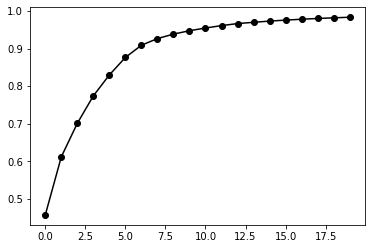

In [46]:
pc_dims = 10
pts_subset = 'enc' # supports 'enc', 'dec', 'all', and 'encf'
no_states = True

# Finds percentage of variance explained by top pc_dims of PCA
# pca_full = PCA(n_components=rnn_specs['hidden_size'])
pca_full = PCA(n_components=np.min([len(hs[pts_subset]), rnn_specs['hidden_size']]))
_ = pca_full.fit_transform(np.vstack(hs[pts_subset]))
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', participation_ratio_vector(pca_full.explained_variance_))
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', participation_ratio_vector(pca_full.explained_variance_))
total_exvar = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(np.vstack(hs[pts_subset]))
print('Readout vec proj via PCA:', pca.transform(readout).T)

# The initial state.
h0 = cell.get_initial_state(rnn_params)[:rnn_specs['hidden_size']]
print('h0 shape', h0.shape)

Example phrase length: 18
Example phrase: ['walk', 'and', 'walk', '<.>', 'run', 'after', 'walk', '<.>', 'walk', 'after', 'run', '<.>', 'run', 'after', 'walk', '<.>', 'walk', 'after', 'walk', '<.>', '<pad>', '<pad>', '<pad>']
Example phrase length: 18
Example phrase: ['walk', 'after', 'run', '<.>', 'walk', 'after', 'walk', '<.>', 'walk', 'and', 'walk', '<.>', 'walk', 'and', 'walk', '<.>', 'run', 'after', 'run', '<.>', '<pad>', '<pad>', '<pad>']
Example phrase length: 18
Example phrase: ['walk', 'after', 'walk', '<.>', 'run', 'after', 'run', '<.>', 'walk', 'and', 'run', '<.>', 'walk', '<.>', 'walk', '<.>', 'run', '<.>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


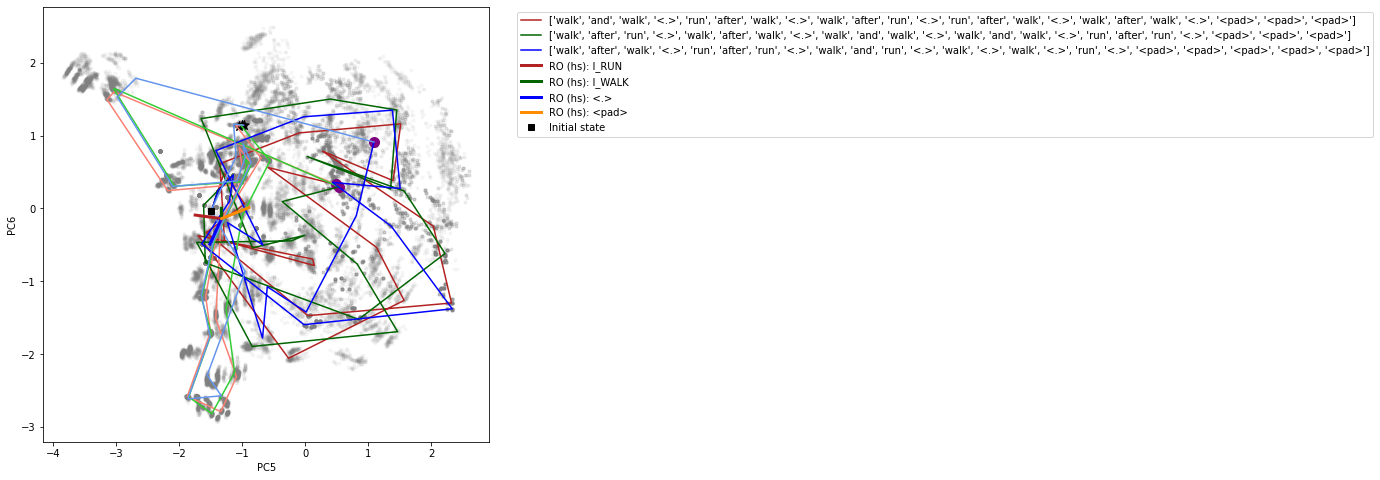

In [52]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pts_subset = 'all'

plt.figure(figsize=(8, 8))

pc1 = 5
pc2 = 6

state_colors = ['firebrick', 'darkgreen', 'blue', 'darkorange', 'm', 'deeppink', 'gray', 'k']
state_colors_light = ['salmon', 'limegreen', 'cornflowerblue', 'bisque']

final_hs_idx = 2*toy_params['phrase_length'] if pts_subset == 'all' and not rnn_specs['arch'] == 'one_to_one' else toy_params['phrase_length']
encode_hs_idx = 0 if pts_subset == 'dec' else input_phrase_len - 1

pca_h0 = pca.transform(np.atleast_2d(h0)).T

# Plots hidden states
fs_alpha = 0.05
pca_hs = pca.transform(np.vstack(hs[pts_subset])).T
if pts_subset == 'all':
  pl = input_phrase_len
  plt.scatter(pca_hs[pc1][:pl], pca_hs[pc2][:pl], color = 'k', marker='.', alpha=fs_alpha)
  plt.scatter(pca_hs[pc1][pl-1:], pca_hs[pc2][pl-1:], color = 'gray', marker='.', alpha=fs_alpha)
else:
  plt.scatter(pca_hs[pc1], pca_hs[pc2], color = 'purple', marker='.', alpha=fs_alpha)
hs_idxs = [0, 1, 2] # [0]
for hs_idx in hs_idxs: # Plots example paths
  print('Example phrase length:', hs_data['index'][hs_idx])
  print('Example phrase:', tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
    pca_state = np.concatenate((pca_h0, pca.transform(hs[pts_subset][hs_idx]).T), axis=1) 
  if pts_subset == 'dec' or pts_subset == 'all':  # Puts star on final hidden state
    pca_decf = pca.transform(np.atleast_2d(hs['decf'][hs_idx])).T
    plt.scatter(pca_decf[pc1], pca_decf[pc2], color = 'k', marker='*', 
                s=100.0, alpha=1.0)
  if pts_subset == 'all':
    plt.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=1.0,
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    plt.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = state_colors_light[hs_idxs.index(hs_idx)], marker=None, alpha=1.0)
  else:
    plt.plot(pca_state[pc1], pca_state[pc2], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=0.5, 
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  plt.scatter(pca_state[pc1, encode_hs_idx+1], pca_state[pc2, encode_hs_idx+1], color = 'purple', marker='o', 
                s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# Positional encoding plotting
# pos_enc_idxs = [0, 1, 2, 3]
# pos_enc_labs = ['0 hot', '1 hot', '2 hot', '3 hot', 'pos enc']
# for pos_enc_idx in pos_enc_idxs:
#   if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
#     pca_state = np.concatenate((pca_h0, pca.transform(hs['pos_enc'][pos_enc_idx]).T), axis=1) 
#   if pts_subset == 'all':
#     plt.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = state_colors[pos_enc_idxs.index(pos_enc_idx)], 
#              marker=None, alpha=1.0, label=pos_enc_labs[pos_enc_idxs.index(pos_enc_idx)])
#     plt.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = state_colors_light[pos_enc_idxs.index(pos_enc_idx)],
#              marker=None, alpha=1.0)
#   else:
#     plt.plot(pca_state[pc1], pca_state[pc2], color =  'k', marker=None, alpha=0.5, 
#               label=pos_enc_labs[pos_enc_idxs.index(pos_enc_idx)])
#   plt.scatter(pca_state[pc1, encode_hs_idx+1], pca_state[pc2, encode_hs_idx+1], color = 'k', marker='o', 
#                 s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# pca_states = pca.transform(np.vstack(hs)).T
# plt.plot(pca_states[pc1], pca_states[pc2], c = 'k', marker='o', alpha=0.01, label='Hidden sates')

# Plots readout direction
readout_type = 'hs' # 'att' or 'hs'
readout_plot = readout if readout_type == 'att' else readout_dec
pca_ro = pca.transform(readout_plot)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout_plot.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label=f'RO ({readout_type}): '+toy_params['out_words'][i])

# path_idxs = [54, 56, 57]
# for path_idx in path_idxs:
#   print('Path labels:', syn_data_test['labels'][path_idx])
#   path_pca = pca.transform(hs[path_idx]).T
#   plt.plot(path_pca[pc1], path_pca[pc2], c='orange', marker='.', label='Random Path')

plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))
plt_lim = None
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
for i in range(12):
  print(f'Example phrase {i}:', tensorToPhrase(hs_data['inputs'][i], toy_params['in_words']))

Example phrase 0: ['run', '<pad>', '<pad>', '<pad>']
Example phrase 1: ['walk', 'and', 'jump', '<pad>']
Example phrase 2: ['jump', 'and', 'run', '<pad>']
Example phrase 3: ['walk', '<pad>', '<pad>', '<pad>']
Example phrase 4: ['run', 'and', 'walk', '<pad>']
Example phrase 5: ['walk', 'and', 'run', '<pad>']
Example phrase 6: ['run', 'and', 'jump', '<pad>']
Example phrase 7: ['run', 'and', 'run', '<pad>']
Example phrase 8: ['jump', 'and', 'jump', '<pad>']
Example phrase 9: ['jump', 'and', 'walk', '<pad>']
Example phrase 10: ['jump', '<pad>', '<pad>', '<pad>']
Example phrase 11: ['walk', 'and', 'walk', '<pad>']


#### Readout Vector Analysis

In [75]:
from itertools import combinations 

def subspace_perc(A, b):
  """
  A: an N x M matrix, whose column space represents some M-dimensional subspace
  b: an N x P vector
  For each of b's columns, finds the percentage of its magnitude which lies in 
  the subspace formed by the columns of A (its columnspace). Then averages these together
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # N x N matrix
  b_proj = np.matmul(proj, b) # N x P martix

  norm_perc = np.linalg.norm(b_proj, axis=0)/np.linalg.norm(b, axis=0) # P dim vector

  return np.mean(norm_perc)

def ro_subspace_analysis(readout):
  readout = np.asarray(readout)
  ro_n = readout.shape[0]
  indices = [i for i in range(ro_n)]
  for ss_dim in range(1, ro_n): # Tries dimensions from 1 to ro_n - 1
    comb = combinations(indices, ss_dim) # Gets all possible combinations
    n_comb = 0
    perc_vals = 0
    for subspace_idxs in list(comb): # For each combination
      n_comb += 1
      A_idxs = list(subspace_idxs)
      b_idxs = list(filter(lambda a: a not in list(subspace_idxs), indices))
      A = readout[A_idxs]
      b = readout[b_idxs] 
      perc_vals += subspace_perc(A.T, b.T)
    print('Avg perc in rest for subspace dim {}:'.format(ss_dim), 1/n_comb * perc_vals)

readout_mags = []
readout_pca_mags = []
pc_dims = 2
for i in range(len(readout)):
  readout_mags.append(np.linalg.norm(readout[i]))
  # readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  print('Readout {} mag:'.format(i), readout_mags[i])
  # print('Readout {}'.format(i), '(perc in first {} PC dims):'.format(pc_dims), readout_pca_mags[i]/readout_mags[i])

for i in range(len(readout)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(readout_mags[i]*readout_mags[j])))

ro_subspace_analysis(readout)

if rnn_specs['arch'] in ['enc_dec_atth']:
  for i in range(len(readout_dec)):
    print('Readout (decoder) {} mag:'.format(i), np.linalg.norm(readout_dec[i]))
    # readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  for i in range(len(readout_dec)):
    print('Readout att/decoder {} dot:'.format(i), 180/np.pi * np.arccos(np.dot(readout[i], readout_dec[i])/
          (np.linalg.norm(readout[i])*np.linalg.norm(readout_dec[i]))))

Readout 0 mag: 6.480975
Readout 1 mag: 6.5342813
Readout 2 mag: 6.631018
Readout 3 mag: 6.7603617
Readout 4 mag: 6.6870217
Readout 5 mag: 6.6434093
Angle (1, 0): 101.57298624168857
Angle (2, 0): 97.600944371381
Angle (2, 1): 98.11951965392505
Angle (3, 0): 103.7488864357687
Angle (3, 1): 102.7519383641353
Angle (3, 2): 104.01242928489364
Angle (4, 0): 101.79137471021055
Angle (4, 1): 104.91264138731215
Angle (4, 2): 100.13446644021384
Angle (4, 3): 97.52163221473882
Angle (5, 0): 100.11384609910957
Angle (5, 1): 98.30473389364829
Angle (5, 2): 109.87993061214976
Angle (5, 3): 98.61775463312081
Angle (5, 4): 99.37410246105134
Avg perc in rest for subspace dim 1: 0.1944017137090365
Avg perc in rest for subspace dim 2: 0.3108882923920949
Avg perc in rest for subspace dim 3: 0.43691460192203524
Avg perc in rest for subspace dim 4: 0.6077600042025249
Avg perc in rest for subspace dim 5: 0.92403843998909
Readout (decoder) 0 mag: 5.7667103
Readout (decoder) 1 mag: 5.9078608
Readout (decoder) 

x 1.0000001
y 0.99999994
x.y 2.2351742e-08
Example phrase length: 13
Example phrase: ['I0', 'I2', 'I3', 'I1', 'I3', 'I3', 'I3', 'I2', 'I0', 'I2', 'I2', 'I0', 'I1', 'I0']


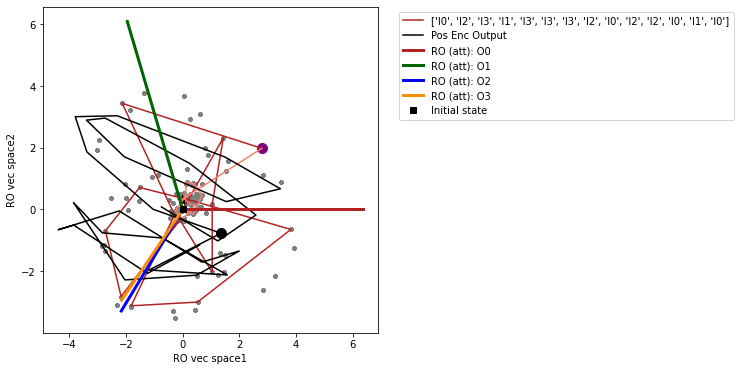

In [24]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
readout_type = 'att' # 'att' or 'hs'
readout_plot = readout if readout_type == 'att' else readout_dec
x_basis = readout_plot[ro1] / np.linalg.norm(readout_plot[ro1])
y_vec = readout_plot[ro2] - np.dot(x_basis, readout_plot[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

h0_x_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), x_basis)
h0_y_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), y_basis)

# Plots hidden states
fs_alpha = 0.05
hs_x_vals = np.dot(np.matmul(np.vstack(hs[pts_subset]), proj), x_basis)
hs_y_vals = np.dot(np.matmul(np.vstack(hs[pts_subset]), proj), y_basis)
if pts_subset == 'all':
  pl = input_phrase_len
  plt.scatter(hs_x_vals[:pl], hs_y_vals[:pl], color = 'k', marker='.', alpha=fs_alpha)
  plt.scatter(hs_x_vals[pl-1:], hs_y_vals[pl-1:], color = 'gray', marker='.', alpha=fs_alpha)
else:
  plt.scatter(hs_x_vals, hs_y_vals, color = 'purple', marker='.', alpha=fs_alpha)

hs_idxs = [0]
for hs_idx in hs_idxs: # Plots example paths
  print('Example phrase length:', hs_data['index'][hs_idx])
  print('Example phrase:', tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
    hs_path_x = np.concatenate((np.asarray([h0_x_val,]), np.dot(np.matmul(np.vstack(hs[pts_subset][hs_idx]), proj), x_basis)))
    hs_path_y = np.concatenate((np.asarray([h0_y_val,]), np.dot(np.matmul(np.vstack(hs[pts_subset][hs_idx]), proj), y_basis)))
  if pts_subset == 'dec' or pts_subset == 'all':  # Puts star on final hidden state
    x_decf = np.dot(np.matmul(hs['decf'][hs_idx], proj), x_basis)
    y_decf = np.dot(np.matmul(hs['decf'][hs_idx], proj), y_basis)
    plt.scatter(x_decf, y_decf, color = 'k', marker='*', 
                s=100.0, alpha=1.0)
  if pts_subset == 'all':
    plt.plot(hs_path_x[:pl+1], hs_path_y[:pl+1], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=1.0,
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    plt.plot(hs_path_x[pl:], hs_path_y[pl:], color = state_colors_light[hs_idxs.index(hs_idx)], marker=None, alpha=1.0)
  else:
    plt.plot(hs_path_x, hs_path_y, color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=0.5, 
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  plt.scatter(hs_path_x[encode_hs_idx+1], hs_path_y[encode_hs_idx+1], color = 'purple', marker='o', 
                s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# Positional encoding plotting
if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
  hs_path_x = np.concatenate((np.asarray([h0_x_val,]), np.dot(np.matmul(np.vstack(hs['pos_enc'][0]), proj), x_basis)))
  hs_path_y = np.concatenate((np.asarray([h0_y_val,]), np.dot(np.matmul(np.vstack(hs['pos_enc'][0]), proj), y_basis)))
if pts_subset == 'all':
  plt.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = 'k', marker=None, alpha=1.0,
            label='Pos Enc Output')
  plt.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = 'k', marker=None, alpha=1.0)
else:
  plt.plot(pca_state[pc1], pca_state[pc2], color =  'k', marker=None, alpha=0.5, 
            label='Pos Enc Output')
plt.scatter(pca_state[pc1, encode_hs_idx+1], pca_state[pc2, encode_hs_idx+1], color = 'k', marker='o', 
              s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# Plots readout direction
pca_ro = pca.transform(readout_plot)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout_plot.shape[0]):
  ro_proj = np.matmul(proj, readout_plot[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], color=state_colors[i], 
           linewidth = 3, label=f'RO ({readout_type}): '+toy_params['out_words'][i])

plt.plot(h0_x_val, h0_y_val, 'ks', label='Initial state')

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt_lim = None
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#### Attention Analysis

Single sequence shape: (41, 128)


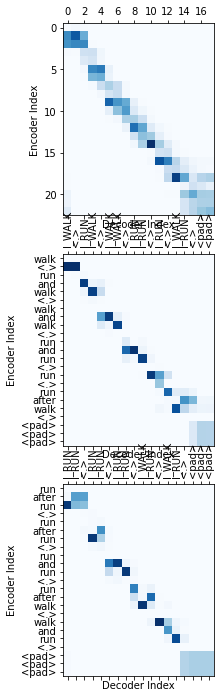

In [44]:
from scipy.special import softmax
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,12))
min_val, max_val = 0, 1

print('Single sequence shape:', hs['all'][0].shape)
enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]
attn_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
for h_idx in range(len(hs['all'])):
  enc_seq = hs['all'][h_idx][:enc_len]
  for seq_idx in range(dec_len):
    attn_matrix[h_idx, :, seq_idx] = softmax(np.dot(enc_seq, hs['all'][h_idx][enc_len + seq_idx]))

mean_attn_matrix = np.mean(attn_matrix, axis=0)
ax1.matshow(mean_attn_matrix, cmap=plt.cm.Blues)

phrase_idxs = [0, 12]

ax1.set_ylabel('Encoder Index')
ax1.set_xlabel('Decoder Index')

for ax, i in zip((ax2, ax3), phrase_idxs):
  ax.matshow(attn_matrix[i], cmap=plt.cm.Blues)
  enc_labels = tensorToPhrase(hs_data['inputs'][i], toy_params['in_words'])
  dec_labels = tensorToPhrase(hs_data['labels'][i], toy_params['out_words'])

  ax.set_ylabel('Encoder Index')
  ax.set_xlabel('Decoder Index')

  ax.set_xticks([j for j in range(dec_len)])
  ax.set_yticks([j for j in range(enc_len)])
  ax.set_yticklabels(enc_labels, rotation=0)
  ax.set_xticklabels(dec_labels, rotation=90)

In [ ]:
soft_max_attn = jax.nn.softmax(att_params, axis=0)

fig, ax = plt.subplots()
min_val, max_val = 0, 1
ax.matshow(soft_max_attn, cmap=plt.cm.Blues)

### Find Fixed Points

In [ ]:
add_noise = True
noise_scale = 0.5
cell_type = 'enc'

word = '<pad>' # 'I0'
if word == None:
  word_tensor = 1/rnn_specs['input_size']*jnp.ones(rnn_specs['input_size'])
elif cell_type == 'enc':
  word_tensor = wordToTensor(word, toy_params['in_words'])[0]
elif cell_type == 'dec':
  word_tensor = wordToTensor(word, toy_params['out_words'])[0]

xstar = np.repeat(word_tensor[np.newaxis, :], pts[pts_subset].shape[0], axis=0)

if add_noise:
  seed_pts = pts[pts_subset] + np.random.normal(loc=0.0, scale=noise_scale, size=pts[pts_subset].shape)
else:
  seed_pts = pts[pts_subset]

if rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
  if cell_type == 'dec':
    print('Decoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell_dec, rnn_params_dec)
  elif cell_type == 'enc':
    print('Encoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
  if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']: # add zeros to hidden state
    null_hs = np.zeros(pts[pts_subset].shape)
    seed_pts = np.concatenate((seed_pts, null_hs), axis=1)
else:
  fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
xstar = jnp.asarray(xstar)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, seed_pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-2)
print('Done')

if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
  fixed_points = fixed_points[:, :rnn_specs['hidden_size']]

pca_fixed_points = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_fixed_points.fit_transform(fixed_points)
print('Fixed Points PR:', participation_ratio_vector(pca_fixed_points.explained_variance_ratio_))
print('% Var Exp:', pca_fixed_points.explained_variance_ratio_[:5])

Encoder fixed points.
Done
Fixed Points PR: 1.0157657504933155
% Var Exp: [9.9219364e-01 5.1310076e-03 2.0770244e-03 3.1081797e-04 1.2073886e-04]


Text(0, 0.5, 'PC5')

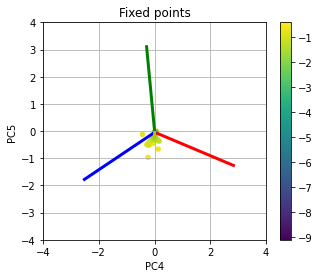

In [ ]:
# 2D Visualization of the approximate fixed points: the line attractor.

pc1 = 4
pc2 = 5

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
# pca_fps = pca.transform(np.vstack(hs_grid_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()

plt.colorbar()

# pca_word = 1*word_deflection('kinda0', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 1*word_deflection('kinda1', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
# plt.plot(pca_h0[pc1], pca_h0[pc2], '*', color='k', ms=18)
plt.title('Fixed points')


plt_lim = 4
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)
plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))

x 1.0
y 1.0
x.y 7.4505806e-08


Text(0, 0.5, 'RO vec space2')

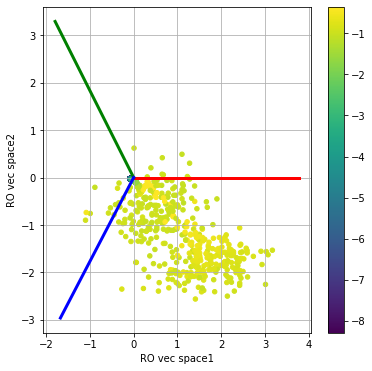

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

if rnn_specs['arch'] in ['enc_dec_atth']:
  h0_x_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), x_basis)
  h0_y_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), y_basis)
else:
  h0_x_val = np.dot(np.matmul(h0, proj), x_basis)
  h0_y_val = np.dot(np.matmul(h0, proj), y_basis)


fps_x_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), x_basis)
fps_y_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), y_basis)
plt.scatter(fps_x_vals, fps_y_vals, s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()
plt.colorbar()

ro_colors = ['r', 'g', 'b', 'y', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

# plt.xlim(-7, 7)
# plt.ylim(-7, 7)

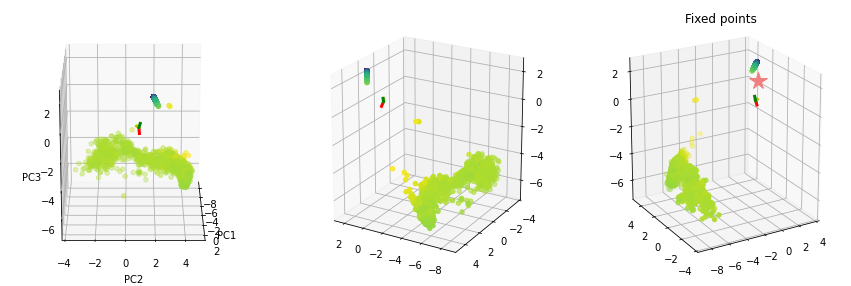

In [ ]:
# triangulate in the underlying parametrization
from matplotlib.tri import Triangulation

pc1 = 0
pc2 = 1
pc3 = 2

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(131, projection='3d');
ax2 = fig.add_subplot(132, projection='3d');
ax3 = fig.add_subplot(133, projection='3d');


pca_fps = pca.transform(np.vstack(fixed_points)).T
# max_loss = np.max(np.log10(fp_losses))
# min_loss = np.min(np.log10(fp_losses))
# loss_range = max_loss - min_loss
# colors = []
# for loss in fp_losses:
#   seq_color_norm = (np.log10(loss)-min_loss)/loss_range
#   colors.append((seq_color_norm, 0, 1 - seq_color_norm, 1.0))
# ax.plot_trisurf(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], edgecolor='none', color='grey')
ax.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))
ax2.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))
ax3.scatter(pca_fps[pc1], pca_fps[pc2], pca_fps[pc3], s=20, c=np.log10(fp_losses))

# Plots readout direction
ro_colors = ['r', 'y', 'g', 'b', 'm']
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  z_ro = [pca_zero[pc3], pca_ro[i][pc3]]
  ax.plot(x_ro, y_ro, z_ro, color=ro_colors[i], linewidth = 3, label='RO'+str(i))
  ax2.plot(x_ro, y_ro, z_ro, color=ro_colors[i], linewidth = 3, label='RO'+str(i))
  ax3.plot(x_ro, y_ro, z_ro, color=ro_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], pca_h0[pc3], '*', color='lightcoral', ms=18)
plt.title('Fixed points')

# pca_word = 3*word_deflection('very1', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 3*word_deflection('very0', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

ax.set_xlabel('PC'+str(pc1+1))
ax.set_ylabel('PC'+str(pc2+1))
ax.set_zlabel('PC'+str(pc3+1))

# Azimuthal angle and rotation
ax.view_init(20, 0)
ax2.view_init(20, 120)
ax3.view_init(20, 240)

#### Fixed Point Grid Search

Mean distance: 2.5539993485659362
Treshold conversion: 26.091650689900906


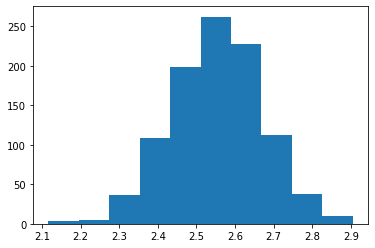

In [ ]:
# Average distance traveled
avg_step_sizes = np.zeros((len(hs),))
for hs_idx in range(len(hs)):
  hs_h0 = np.concatenate([hs[hs_idx], h0[np.newaxis, :]], axis=0)
  total_dist = 0
  for time_idx in range(hs_h0.shape[0] - 1):
    total_dist += np.sqrt(np.sum((hs_h0[time_idx+1] - hs_h0[time_idx])**2))
  avg_step_sizes[hs_idx] = total_dist/hs[hs_idx].shape[0]

print('Mean distance:', np.mean(avg_step_sizes))
print('Treshold conversion:', (2*np.mean(avg_step_sizes))**2)

# Histogram of mean distance
plt.hist(avg_step_sizes, bins=10)
plt.show()

In [ ]:
cell_type = 'enc'
word = 'I0'
if word == None:
  word_tensor = jnp.zeros(rnn_specs['input_size'])
elif cell_type == 'enc':
  word_tensor = wordToTensor(word, toy_params['in_words'])[0]
elif cell_type == 'dec':
  word_tensor = wordToTensor(word, toy_params['out_words'])[0]

pca_full = PCA(n_components=rnn_specs['hidden_size'])
pts_pca = pca_full.fit_transform(pts[pts_subset])
pr_hs = participation_ratio_vector(pca_full.explained_variance_)
print('Participation Ratio of Hidden States:', pr_hs)

grid_dims = np.int(np.ceil(pr_hs))
print("Grid over first {} PC dimensions".format(grid_dims))

range_extend_ratio = 1 # Amount to extend total range
max_points = 30 # Maximum points along biggest dimension
grid_coords = []
spacing = 0

for dim_idx in range(grid_dims):
  max_co = np.max(pts_pca[:,dim_idx])
  min_co = np.min(pts_pca[:,dim_idx])
  range_co = np.copy(max_co - min_co)

  max_co += range_extend_ratio/2 * range_co # Extend range
  min_co -= range_extend_ratio/2 * range_co

  if dim_idx == 0:
    spacing = (max_co - min_co)/max_points                                    

  if dim_idx == 2 or dim_idx == 3: # hack to set certain dimensions to zero points
    max_co, min_co = 1e-5, 0

  grid_coords.append(np.linspace(min_co, max_co, num=np.int(np.ceil((max_co - min_co)/spacing))))
  print('In PC{} dim, using {} points'.format(dim_idx, np.int(np.ceil((max_co - min_co)/spacing))))

# Creates grid and turns them into PCA points
grid_vals = np.asarray(np.meshgrid(*grid_coords))
grid_vals_flat = grid_vals.reshape(grid_vals.shape[0], np.prod(grid_vals.shape[1:]))
print('Total hidden states:',  np.prod(grid_vals.shape[1:]))
pca_points = np.zeros((grid_vals_flat.shape[1], rnn_specs['hidden_size']))
pca_points[:, :grid_dims] = grid_vals_flat.T

# Transform back into hidden state space
hs_grid_points =  jnp.asarray(pca_full.inverse_transform(pca_points))
if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']: # add zeros to hidden state
  null_hs = np.zeros(hs_grid_points.shape)
  hs_grid_points = np.concatenate((hs_grid_points, null_hs), axis=1)

print('Hs grid points shape', hs_grid_points.shape)

# Fixed point state search
hs_ones = jnp.ones((hs_grid_points.shape[0],))

xstar = np.repeat(word_tensor[np.newaxis, :], hs_grid_points.shape[0], axis=0)

if rnn_specs['arch'] == 'enc_dec':
  if cell_type == 'dec':
    print('Decoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell_dec, rnn_params_dec)
  elif cell_type == 'enc':
    print('Encoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
else:
  fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)

fp_losses = fp_loss_fun(hs_grid_points, xstar)

Participation Ratio of Hidden States: 2.5238600957823096
Grid over first 3 PC dimensions
In PC0 dim, using 30 points
In PC1 dim, using 28 points
In PC2 dim, using 1 points
Total hidden states: 840
Hs grid points shape (840, 256)


In [ ]:
thresh = 1.0
hs_grid_thresh = hs_grid_points[fp_losses < thresh]
fp_losses_thresh = fp_losses[fp_losses < thresh]
print('Number of points', hs_grid_thresh.shape[0])

k_val = 100
r_range = (-0.5, 0)

pca_fps = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_fps.fit_transform(hs_grid_thresh)
explained_var = pca_fps.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', participation_ratio_vector(pca_fps.explained_variance_))

distances = pdist(hs_grid_thresh, metric="euclidean") # n_fp * (n_fps-1) / 2
dist_sq = squareform(distances) # n_fp x n_fp 

Number of points 548
Top 5 components: 1.0 ( [4.3972242e-01 4.2912185e-01 1.3115574e-01 2.8854531e-13 1.5325461e-15] )
Participation Ratio: 2.5335490180705964


#### Single Fixed Point Analysis

Text(0, 0.5, 'PC2')

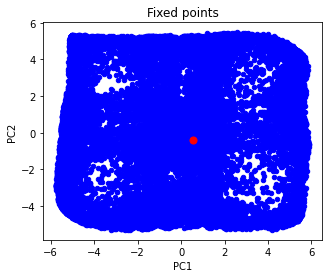

In [ ]:
# Pick a fixed point.
# fp_idx = np.argmin(fp_losses)
fp_idx = 350
fp = fixed_points[fp_idx]

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')
plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='r')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [ ]:
# Computes the recurrent Jacobian.
jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), fp))

# Perform an eigendecomposition to get eigenvectors and eigenvalues.
R, E, L = renn.eigsorted(jac)

Text(0, 0.5, 'imag')

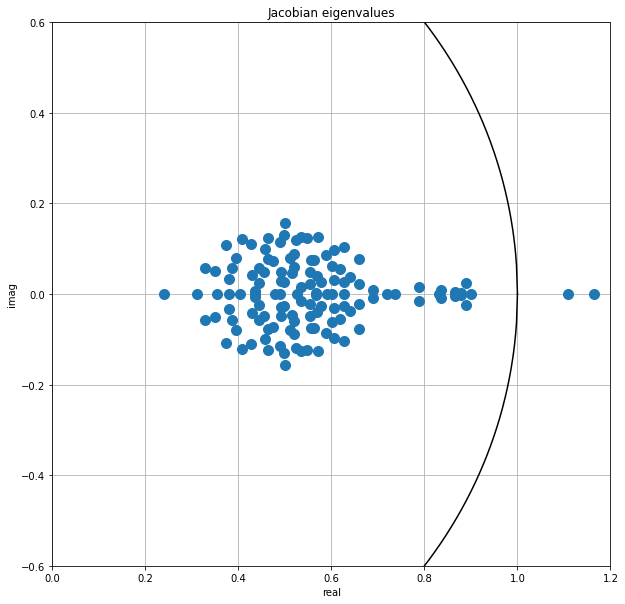

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(np.real(E), np.imag(E), 'o', ms=10)
plt.grid()
plt.xlim(0, 1.2)
plt.ylim(-0.6, 0.6)
# Makes unit circle
x = np.linspace(-1, 1, 1000)
plt.plot(x, np.sqrt(1-x**2), 'k')
plt.plot(x, -np.sqrt(1-x**2), 'k')

plt.title('Jacobian eigenvalues')
plt.xlabel('real')
plt.ylabel('imag')

#### Many Fixed Point Analysis

In [ ]:
# Jacobian projections
def word_deflection(word, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns (linearized) deflection of word from hs in terms of pcs of comp""" 
  word_tensor = wordToTensor(word, toy_params['words'])
  input_jac = cell.inp_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs)
  hidden_update = np.matmul(input_jac, word_tensor[0])
  
  return np.matmul(comp, hidden_update)

def hs_modes(n_eigs, cell, toy_params, rnn_params, rnn_specs, hs, comp):
  """ Returns deflection of top n_eigs eigenvalues from hs in terms of pcs of comp""" 
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs))
  R, E, L = renn.eigsorted(jac)

  print('HS top eigenvalues:', E[:n_eigs+1])

  return np.matmul(comp, R[:, :n_eigs]).T

In [ ]:
# Plots Jacobian eigenvalues as a function of fixed point

pca_fps = pca.transform(np.vstack(fixed_points)).T

# Sorts fixed points by pc dimension
# sort_idxs = np.argsort(pca_fps[0])
# sorted_pca_fps = pca_fps[0][sort_idxs]
# sorted_fp = fixed_points[sort_idxs]

# Sorts fixed points by distance from mean fixed point
fp_mean = np.mean(fixed_points, axis=0)
fp_dist = np.zeros((fixed_points.shape[0],))
for fp_idx in range(fixed_points.shape[0]):
  fp_dist[fp_idx] = np.linalg.norm(fixed_points[fp_idx]-fp_mean, ord=1)
sort_idxs = np.argsort(fp_dist)
sorted_fpidx = fp_dist[sort_idxs]
sorted_fp = fixed_points[sort_idxs]


take_every = 25
n_top = 8
n_fp = len(fixed_points)
print('Evaluating {} fixed points.'.format(n_fp))
max_evals = np.zeros((int(n_fp/take_every), n_top))
max_evals_im = np.zeros((int(n_fp/take_every), n_top))
pc_dim_val = np.zeros(int(n_fp/take_every))

for i in tqdm(range(0, int(n_fp/take_every))):
  fp = sorted_fp[i*take_every]
  jac = jax.device_get(cell.rec_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), fp))
  _, E, _ = renn.eigsorted(jac)
  rE = np.real(E)
  iE = np.imag(E)
  rE.sort()
  iE.sort()
  pc_dim_val[i] = sorted_fpidx[i*take_every]
  max_evals[i] = rE[-n_top:]
  max_evals_im[i] = iE[-n_top:]

Evaluating 10000 fixed points.


Text(0, 0.5, 'Top Im(Eigenvalues)')

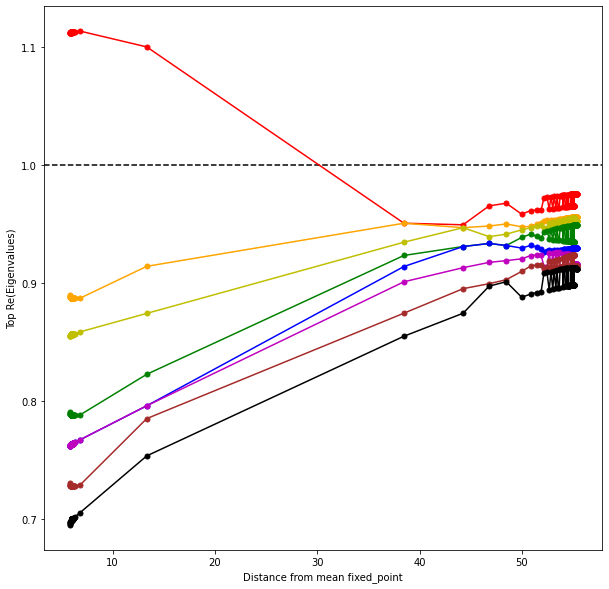

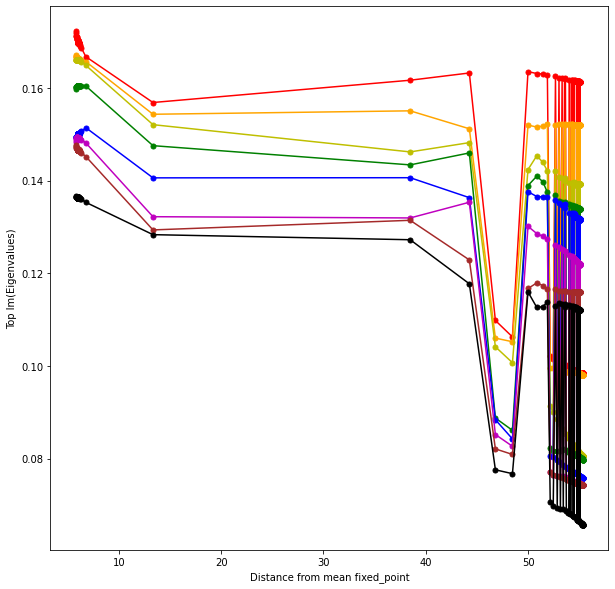

In [ ]:
plt.figure(figsize=(10,10))
plt.axhline(1.0, c='k', linestyle='--')
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Re(Eigenvalues)')

plt.figure(figsize=(10,10))
colors = ['r', 'orange', 'y', 'g', 'b', 'm', 'brown', 'k']
for i in range(n_top):
  plt.plot(pc_dim_val, max_evals_im[:,n_top-1-i], '.-', ms=10, c=colors[i])

plt.xlabel('PC1')
plt.xlabel('Distance from mean fixed_point')
plt.ylabel('Top Im(Eigenvalues)')

In [ ]:
print('Number of fixed points:', len(fixed_points))

Number of fixed points: 25000


HS top eigenvalues: [0.8956536+0.j 0.8526117+0.j 0.8031965+0.j]
HS top eigenvalues: [0.89565367+0.j 0.8526116 +0.j 0.8031965 +0.j]
HS top eigenvalues: [1.1041673 +0.j 0.86134094+0.j 0.8294861 +0.j]
HS top eigenvalues: [1.1124028 +0.j 0.8614164 +0.j 0.81864643+0.j]
HS top eigenvalues: [1.0988455 +0.j 0.85771126+0.j 0.8039921 +0.j]


Text(0, 0.5, 'PC2')

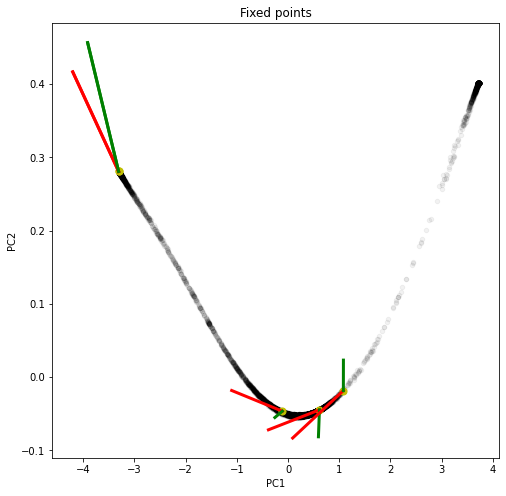

In [ ]:
# Zero modes
fp_idxs =[600, 1000, 4000, 22000, 24000]
num_eigs = 2
scale = 1 # Amount to scale up eigenvalues

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1
plt.figure(figsize=(8, 8))

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[pc1])
sorted_fp = fixed_points[sort_idxs]

pca_fps = pca.transform(np.vstack(sorted_fp)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], alpha=0.05, s=20, c='k')

eig_colors = ['r', 'g', 'm', 'b', 'orange', 'grey']
for fp_idx in fp_idxs:
  mode_proj = scale * np.real(hs_modes(num_eigs, cell, toy_params, rnn_params, rnn_specs, sorted_fp[fp_idx], comp))
  for i in range(num_eigs):
    plt.plot(pca_fps[pc1][fp_idx] + [0, mode_proj[i][pc1]], pca_fps[pc2][fp_idx] + [0, mode_proj[i][pc2]], eig_colors[i], linewidth=3)
  plt.scatter(pca_fps[pc1][fp_idx], pca_fps[pc2][fp_idx], s=50, c='y')

plt.title('Fixed points')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

In [ ]:
word_tensor = wordToTensor('not', toy_params['words'])

# Finds deflection of RNNs for a given input
ref_idx = 400
ref_fp = fixed_points[ref_idx]
def_state = cell.apply(rnn_params, word_tensor[0], ref_fp)
delta_hnot_ref = def_state - ref_fp
delta_hnot_ref_mag = np.linalg.norm(delta_hnot_ref)

# Sorts fixed points by pc1 dimension
pca_fps = pca.transform(np.vstack(fixed_points)).T
sort_idxs = np.argsort(pca_fps[0])
sorted_pca_fps = pca_fps[0][sort_idxs]
sorted_fp = fixed_points[sort_idxs]

take_every = 10
n_fp = len(fixed_points)
n_eval = int(n_fp/take_every)

def_state = np.zeros((n_eval, rnn_specs['hidden_size']))
delta_hnot = np.zeros((n_eval, rnn_specs['hidden_size']))
hnot_angles = np.zeros((n_eval,))
hnot_mags = np.zeros((n_eval,))
pc_dim_val = np.zeros((n_eval,))
for i in tqdm(range(0, n_eval)):
  def_state[i] = cell.apply(rnn_params, word_tensor[0], sorted_fp[i*take_every])
  delta_hnot[i] = def_state[i] - sorted_fp[i*take_every]
  pc_dim_val[i] = sorted_pca_fps[i*take_every]
  hnot_mags[i] = np.linalg.norm(delta_hnot[i])
  hnot_angles[i] = 180/np.pi * np.arccos(np.dot(delta_hnot[i], delta_hnot_ref)/(hnot_mags[i]*delta_hnot_ref_mag))

delta_hnot_mean = np.mean(delta_hnot)
hnot_perc_diff = np.zeros((n_eval,))
for i in range(0, n_eval):
  mean_diff = delta_hnot[i] - delta_hnot_mean
  hnot_perc_diff[i] = np.linalg.norm(mean_diff)/hnot_mags[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in arccos


Text(0, 0.5, 'Perc diff from mean')

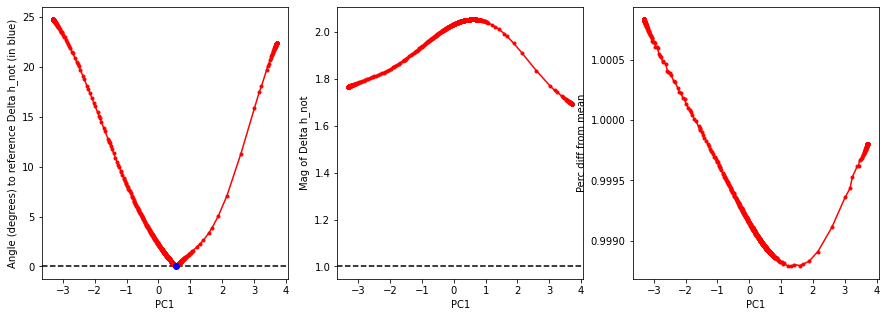

In [ ]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot('131')
ax1.axhline(0.0, c='k', linestyle='--')
ax1.plot(pc_dim_val, hnot_angles, 'r-', marker='.')
ax1.plot(pca_fps[0][ref_idx], [0.0], 'b-o')

ax1.set_xlabel('PC1')
ax1.set_ylabel('Angle (degrees) to reference Delta h_not (in blue)')

ax2 = plt.subplot('132')
ax2.axhline(1.0, c='k', linestyle='--')
ax2.plot(pc_dim_val, hnot_mags, 'r-', marker='.')

ax2.set_xlabel('PC1')
ax2.set_ylabel('Mag of Delta h_not')

ax3 = plt.subplot('133')
ax3.plot(pc_dim_val, hnot_perc_diff, 'r-', marker='.')

ax3.set_xlabel('PC1')
ax3.set_ylabel('Perc diff from mean')

Text(0, 0.5, 'PC2')

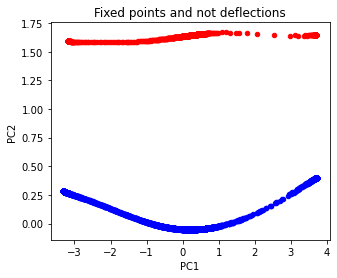

In [ ]:
# Plots fixed points and deflected states

# 2D Visualization of where said fixed point is
pc1 = 0
pc2 = 1

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c='b')

pca_defs = pca.transform(np.vstack(def_state)).T
plt.scatter(pca_defs[pc1], pca_defs[pc2], s=20, c='r')

plt.title('Fixed points and not deflections')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))

#### Readout Space Projection

x 0.99999994
y 0.99999994
x.y -4.4703484e-08


(-7.0, 7.0)

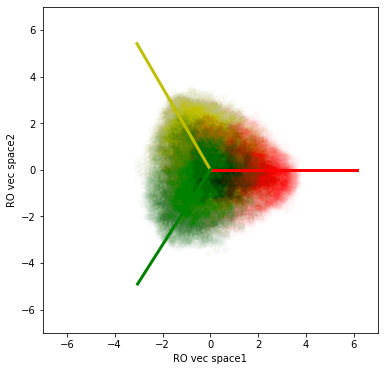

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(toy_params['sentiments'])):
  x_vals = np.dot(np.matmul(np.vstack(states[i]), proj), x_basis)
  y_vals = np.dot(np.matmul(np.vstack(states[i]), proj), y_basis)
  plt.plot(x_vals, y_vals, state_colors[i]+'o', alpha=0.01, label=state_labels[i])

ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt.xlim(-7, 7)
plt.ylim(-7, 7)

x 0.99999994
y 0.99999994
x.y -4.4703484e-08


(-7.0, 7.0)

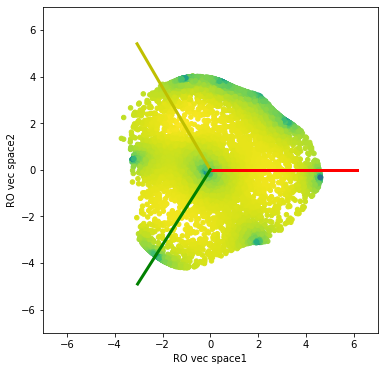

In [ ]:
# Project fixed points onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

# Fixed points
x_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), x_basis)
y_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), y_basis)
plt.scatter(x_vals, y_vals, s=20, c=np.log10(fp_losses))
plt.colorbar

ro_colors = ['r', 'y', 'g', 'b', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt.xlim(-7, 7)
plt.ylim(-7, 7)

### Temporal Analysis

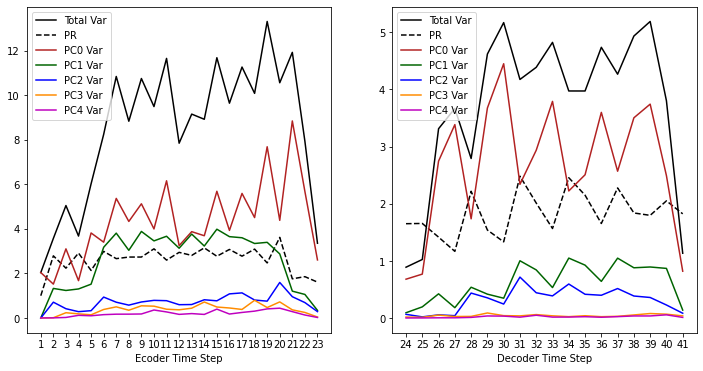

In [54]:
# Plots various variances and the participation ratio of hidden states as a function of time step 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

pc_dims = 5

time_var = np.zeros((hs['all'][0].shape[0]))
time_pr = np.zeros((hs['all'][0].shape[0]))
time_pc_var = np.zeros((hs['all'][0].shape[0], pc_dims))

for time_idx in range(hs['all'][0].shape[0]):
  time_hs = np.asarray([hs['all'][i][time_idx] for i in range(len(hs['all']))])
  pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
  _ = pca_time.fit_transform(time_hs)
  time_var[time_idx] = np.sum(pca_time.explained_variance_)
  time_pr[time_idx] = participation_ratio_vector(pca_time.explained_variance_)
  time_pc_var[time_idx] = pca_time.explained_variance_[:pc_dims]

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
enc_times = [i+1 for i in range(enc_len)]
dec_times = [i+1+enc_len for i in range(dec_len)]
ax1.plot(enc_times, time_var[:enc_len], color='k', label='Total Var')
ax1.plot(enc_times, time_pr[:enc_len], color='k', linestyle='dashed', label='PR')
ax2.plot(dec_times, time_var[enc_len:], color='k', label='Total Var')
ax2.plot(dec_times, time_pr[enc_len:], color='k', linestyle='dashed', label='PR')
for i in range(pc_dims):
  ax1.plot(enc_times, time_pc_var[:enc_len, i], color=state_colors[i], label=f'PC{i} Var')
  ax2.plot(dec_times, time_pc_var[enc_len:, i], color=state_colors[i], label=f'PC{i} Var')

ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')
ax1.set_xticks(enc_times)
ax2.set_xticks(dec_times)

ax1.legend()
ax2.legend()

In [ ]:
# Plots variances of hidden states corresponding to individual inputs/ouput words as a function of time step 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

words = np.max([len(toy_params['in_words']), len(toy_params['out_words'])])
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
all_hs_array = np.asarray(hs['all'])

word_var = np.zeros((hs['all'][0].shape[0], words))

for time_idx in range(enc_len):
  for inp_idx in range(len(toy_params['in_words'])):
    time_hs = np.asarray([h for h, inp in zip(all_hs_array[:, time_idx, :], hs_data['inputs'][:, time_idx, :]) if np.argmax(inp) == inp_idx]) 
    pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
    _ = pca_time.fit_transform(time_hs)
    word_var[time_idx, inp_idx] = np.sum(pca_time.explained_variance_)
for time_idx in range(enc_len, enc_len+dec_len):
  for out_idx in range(len(toy_params['out_words'])):
    time_hs = np.asarray([h for h, out in zip(all_hs_array[:, time_idx, :], hs_data['labels'][:, time_idx, :]) if np.argmax(out) == out_idx]) 
    pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
    _ = pca_time.fit_transform(time_hs)
    word_var[time_idx, out_idx] = np.sum(pca_time.explained_variance_)

enc_times = [i+1 for i in range(enc_len)]
dec_times = [i+1+enc_len for i in range(dec_len)]
for inp_idx in range(len(toy_params['in_words'])):
  ax1.plot(enc_times, word_var[:enc_len, inp_idx], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])
for out_idx in range(len(toy_params['out_words'])):
  ax2.plot(dec_times, word_var[enc_len:, out_idx], color=state_colors[out_idx], label=toy_params['out_words'][out_idx])

ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')
ax1.set_ylabel('Variance')
ax2.set_ylabel('Variance')
ax1.set_xticks(enc_times)
ax2.set_xticks(dec_times)

ax1.legend()
ax2.legend()

Var ex ratios: [0.33689034 0.25519192 0.17586895 0.08168731 0.03632014]
PR: 3.6081787621441377


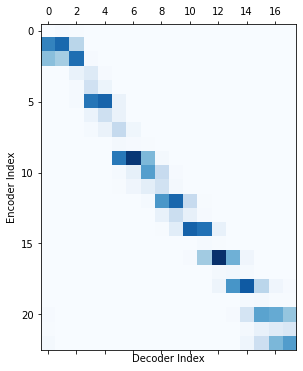

In [60]:
# Checks to see if attention matrix can be explained by average of hidden states at a given time step
from scipy.special import softmax

avg_hs = np.zeros((hs['all'][0].shape))

for time_idx in range(hs[pts_subset][0].shape[0]):
  time_hs = np.asarray([hs[pts_subset][i][time_idx] for i in range(len(hs[pts_subset]))])
  avg_hs[time_idx] = np.mean(time_hs, axis=0)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

attn_matrix = np.zeros((enc_len, dec_len))
enc_seq = avg_hs[:enc_len, :]
for seq_idx in range(dec_len):
  attn_matrix[:, seq_idx] = softmax(np.dot(enc_seq, avg_hs[enc_len + seq_idx, :]))

ax1.matshow(attn_matrix, cmap=plt.cm.Blues)
ax1.set_ylabel('Encoder Index')
ax1.set_xlabel('Decoder Index')

# pca_avg = PCA(n_components=np.min([avg_hs.shape[0], rnn_specs['hidden_size']]))
pca_avg = PCA(n_components=5)
_ = pca_avg.fit_transform(avg_hs[:]).T
pca_avg_hs = pca_avg.transform(avg_hs).T
pca_avg_input = pca_avg.transform(hs['pos_enc'][-1]).T
print('Var ex ratios:', pca_avg.explained_variance_ratio_[:5])
print('PR:', participation_ratio_vector(pca_avg.explained_variance_))

0
100
200
300
400
500
600
700
800
900
Var ex ratios: [0.33689034 0.25519192 0.17586895 0.08168731 0.03632014]
PR: 4.558923509021973


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


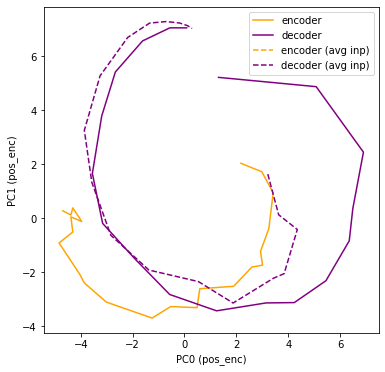

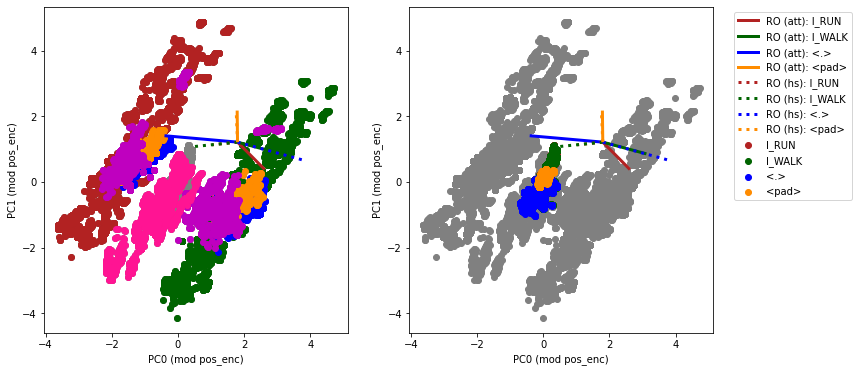

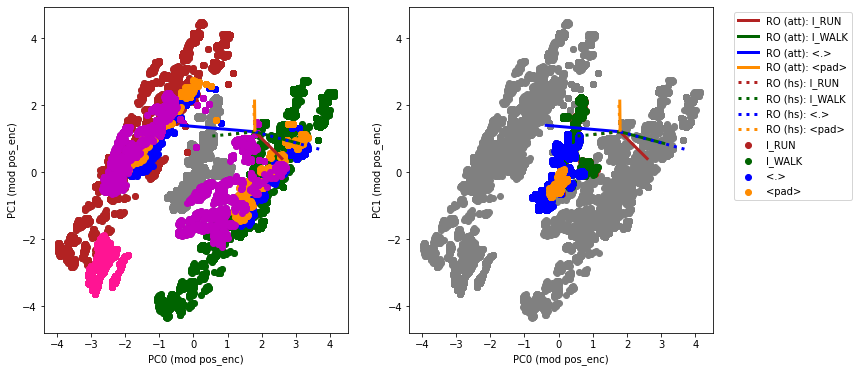

In [61]:
# Plots decomposition of hidden states into temporal and word spaces
avg_hs = np.zeros((hs['all'][0].shape))
enc_len = hs_data['inputs'][0].shape[0]
dec_len = toy_params['phrase_length']

for time_idx in range(hs[pts_subset][0].shape[0]):
  time_hs = np.asarray([hs[pts_subset][i][time_idx] for i in range(len(hs[pts_subset]))])
  avg_hs[time_idx] = np.mean(time_hs, axis=0)

hs_mod_pos_enc = []

for hs_idx in range(len(hs['all'])):
  hs_mod_pos_enc.append(hs['all'][hs_idx] - avg_hs)

hs_inputs = [[] for _ in range(rnn_specs['input_size'])]
hs_outputs = [[] for _ in range(rnn_specs['output_size'])]
hs_inputs_bare = [[] for _ in range(rnn_specs['input_size'])]
hs_outputs_bare = [[] for _ in range(rnn_specs['output_size'])]
for hs_idx in range(len(hs['all'])):
  if hs_idx % 100 == 0: print(hs_idx)
  for inp_idx in range(rnn_specs['input_size']):
    for h, hb, inp in zip(hs_mod_pos_enc[hs_idx][:enc_len], hs['all'][hs_idx][:enc_len], hs_data['inputs'][hs_idx]):
      if np.argmax(inp) == inp_idx:
         hs_inputs[inp_idx].append(h)
         hs_inputs_bare[inp_idx].append(hb)
  for out_idx in range(rnn_specs['input_size']):
    for h, hb, out in zip(hs_mod_pos_enc[hs_idx][enc_len:], hs['all'][hs_idx][enc_len:], hs_data['labels'][hs_idx]):
      if np.argmax(out) == out_idx:
         hs_outputs[out_idx].append(h)
         hs_outputs_bare[out_idx].append(hb)

fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 6))
fig3, (ax4, ax5) = plt.subplots(1, 2, figsize=(12, 6))

pca_avg = PCA(n_components=np.min([avg_hs.shape[0], rnn_specs['hidden_size']]))
# pca_avg = PCA(n_components=5)
_ = pca_avg.fit_transform(avg_hs[:]).T
pca_avg_hs = pca_avg.transform(avg_hs).T
pca_avg_input = pca_avg.transform(hs['pos_enc'][-1]).T
print('Var ex ratios:', pca_avg.explained_variance_ratio_[:5])
print('PR:', participation_ratio_vector(pca_avg.explained_variance_))

pc1 = 0
pc2 = 1

ax1.plot(pca_avg_hs[pc1,:enc_len], pca_avg_hs[pc2,:enc_len], color='orange', label='encoder')
ax1.plot(pca_avg_hs[pc1,enc_len:], pca_avg_hs[pc2,enc_len:], color='purple', label='decoder')
ax1.plot(pca_avg_input[pc1,:enc_len], pca_avg_input[pc2,:enc_len], color='orange', linestyle='dashed', label='encoder (avg inp)')
ax1.plot(pca_avg_input[pc1,enc_len:], pca_avg_input[pc2,enc_len:], color='purple', linestyle='dashed', label='decoder (avg inp)')
ax1.legend()

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])
pca_mod_pe_hs = pca_mod_pe.fit_transform(np.vstack(hs_mod_pos_enc)).T
pca_hs = pca_mod_pe.transform(np.vstack(hs['all'])).T
ax2.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
ax4.scatter(pca_hs[pc1], pca_hs[pc2], color='grey')
for inp_idx in range(rnn_specs['input_size']):
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_inputs[inp_idx])).T
  ax2.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])
  pca_word = pca_mod_pe.transform(np.vstack(hs_inputs_bare[inp_idx])).T
  ax4.scatter(pca_word[pc1], pca_word[pc2], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])

ax3.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
ax5.scatter(pca_hs[pc1], pca_hs[pc2], color='grey')
for out_idx in range(rnn_specs['output_size']):
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_outputs[out_idx])).T
  ax3.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[out_idx], label=toy_params['out_words'][out_idx])
  pca_word = pca_mod_pe.transform(np.vstack(hs_outputs_bare[out_idx])).T
  ax5.scatter(pca_word[pc1], pca_word[pc2], color=state_colors[out_idx], label=toy_params['out_words'][out_idx])

# Average directions of hidden states for encoder/decoder (used to project readouts)
avg_enc = np.mean(avg_hs[:enc_len], axis=0)
avg_dec = np.mean(avg_hs[enc_len:], axis=0)
avg_enc_dir = avg_enc/(np.linalg.norm(avg_enc))
avg_dec_dir = avg_dec/(np.linalg.norm(avg_dec))

# Plots readout direction
readout_types = ['att', 'hs']  #'att', 'hs', 'sum'] # 'att' or 'hs'
ro_styles = ['solid', 'dotted', 'dashed']
for idx in range(len(readout_types)):
  if readout_types[idx] == 'att':
    readout_plot = readout 
    # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
  elif readout_types[idx] == 'hs':
    readout_plot = readout_dec
    # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
  elif readout_types[idx] == 'sum':
    readout_plot = readout + readout_dec
  pca_ro = pca_avg.transform(readout_plot)
  pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
  for i in range(readout_plot.shape[0]):
    x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
    y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
    for ax in [ax2, ax3, ax4, ax5]:
      ax.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, linestyle=ro_styles[idx],
              label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax1.set_xlabel('PC'+str(pc1)+' (pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (pos_enc)')
for ax in [ax2, ax3, ax4, ax5]:
  ax.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
  ax.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

for ax in [ax1, ax2]:
  plt_lim = None
  if plt_lim != None:
    ax.xlim(-plt_lim, plt_lim)
    ax.ylim(-plt_lim, plt_lim)

In [78]:
# Analyzing average encoder/decoder hidden states
avg_word_vec_enc = np.asarray(list(map(lambda l: np.mean(np.asarray(l), axis=0), hs_inputs)))
avg_word_vec_dec = np.asarray(list(map(lambda l: np.mean(np.asarray(l), axis=0), hs_outputs)))

enc_vec_mags = []
for i in range(avg_word_vec_enc.shape[0]):
  enc_vec_mags.append(np.linalg.norm(avg_word_vec_enc[i]))
  print(f'Encoder vec {i} mag:', enc_vec_mags[i])
dec_vec_mags = []
for i in range(avg_word_vec_dec.shape[0]):
  dec_vec_mags.append(np.linalg.norm(avg_word_vec_dec[i]))
  print(f'Decoder vec {i} mag:', dec_vec_mags[i])

for i in range(avg_word_vec_enc.shape[0]):
  for j in range(i):
    print(f'Enc Angle ({i}, {j}):', 180/np.pi * np.arccos(np.dot(avg_word_vec_enc[i], avg_word_vec_enc[j])/(enc_vec_mags[i]*enc_vec_mags[j])))
for i in range(avg_word_vec_dec.shape[0]):
  for j in range(i):
    print(f'Dec Angle ({i}, {j}):', 180/np.pi * np.arccos(np.dot(avg_word_vec_dec[i], avg_word_vec_dec[j])/(dec_vec_mags[i]*dec_vec_mags[j])))

ro_subspace_analysis(avg_word_vec_enc)
ro_subspace_analysis(avg_word_vec_dec)


Encoder vec 0 mag: 2.4652389402916404
Encoder vec 1 mag: 2.3396069035996505
Encoder vec 2 mag: 2.5141381008466244
Encoder vec 3 mag: 2.291354091119812
Encoder vec 4 mag: 2.5220222844186395
Encoder vec 5 mag: 2.545835409784851
Decoder vec 0 mag: 0.026608301459058126
Decoder vec 1 mag: 0.02353978084778032
Decoder vec 2 mag: 0.028338391853811512
Decoder vec 3 mag: 0.024527157564002904
Decoder vec 4 mag: 0.042009010634352445
Decoder vec 5 mag: 0.029838474156993287
Enc Angle (1, 0): 104.28300869725037
Enc Angle (2, 0): 92.53176128419982
Enc Angle (2, 1): 96.42230693258706
Enc Angle (3, 0): 107.49738042356859
Enc Angle (3, 1): 99.00231437391587
Enc Angle (3, 2): 105.84180872778059
Enc Angle (4, 0): 103.05142623308203
Enc Angle (4, 1): 105.69780511774742
Enc Angle (4, 2): 97.9058643533166
Enc Angle (4, 3): 101.01484169639619
Enc Angle (5, 0): 101.67559563975627
Enc Angle (5, 1): 97.59335333313373
Enc Angle (5, 2): 116.07696827263244
Enc Angle (5, 3): 92.53414325328872
Enc Angle (5, 4): 102.64

In [63]:
# Trying to project out temporal average direction from readouts

avg_hs = np.zeros((hs['all'][0].shape))
enc_len = hs_data['inputs'][0].shape[0]
dec_len = toy_params['phrase_length']

for time_idx in range(hs[pts_subset][0].shape[0]):
  time_hs = np.asarray([hs[pts_subset][i][time_idx] for i in range(len(hs[pts_subset]))])
  avg_hs[time_idx] = np.mean(time_hs, axis=0)

avg_enc = np.mean(avg_hs[:enc_len], axis=0)
avg_dec = np.mean(avg_hs[enc_len:], axis=0)
avg_enc_dir = avg_enc/(np.linalg.norm(avg_enc))
avg_dec_dir = avg_dec/(np.linalg.norm(avg_dec))

for i in range(readout_plot.shape[0]):
  print((readout_plot[i] - avg_enc_dir * np.dot(avg_enc_dir, readout_plot[i]))[:3])

print((readout_plot - np.outer(np.dot(readout_plot, avg_enc_dir), avg_enc_dir))[:,:3])

[ 0.87062144 -0.19075848  0.8791499 ]
[-0.5702816  -0.00341941 -0.52204454]
[ 0.16511059  0.2556735  -0.10206616]
[-0.02801782 -0.12301649  1.2021365 ]
[-0.419832   -0.7765885  -0.58014095]
[-0.12773514  1.1069115  -0.8616322 ]
[[ 0.87062144 -0.19075848  0.8791499 ]
 [-0.5702816  -0.00341941 -0.52204454]
 [ 0.16511059  0.2556735  -0.10206616]
 [-0.02801782 -0.12301649  1.2021365 ]
 [-0.419832   -0.7765885  -0.58014095]
 [-0.12773514  1.1069115  -0.8616322 ]]


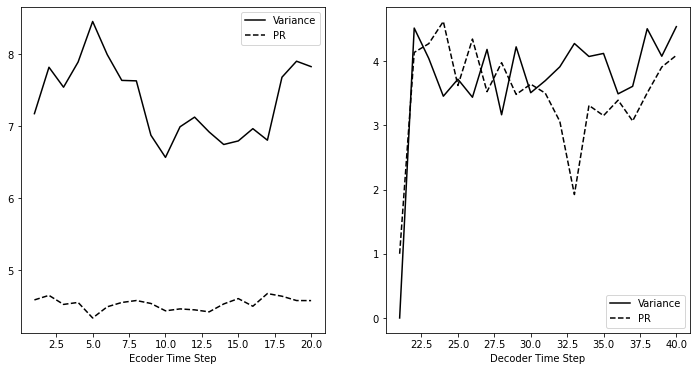

In [260]:
# Plots variances of particular inputs/output states before and after average hidden state is subtracted

pts_subset = 'all'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

time_var = np.zeros((hs['all'][0].shape[0]))

avg_hs = np.zeros((hs['all'][0].shape))
enc_len = hs_data['inputs'][0].shape[0]
dec_len = toy_params['phrase_length']

for time_idx in range(hs[pts_subset][0].shape[0]):
  time_hs = np.asarray([hs[pts_subset][i][time_idx] for i in range(len(hs[pts_subset]))])
  avg_hs[time_idx] = np.mean(time_hs, axis=0)

hs_mod_pos_enc = []

for hs_idx in range(len(hs['all'])):
  hs_mod_pos_enc.append(hs['all'][hs_idx] - avg_hs)

hs_inputs = [[] for _ in range(rnn_specs['input_size'])]
for hs_idx in range(len(hs['all'])):
  if hs_idx % 100 == 0: print(hs_idx)
  for inp_idx in range(rnn_specs['input_size']):
    for h, inp in zip(hs_mod_pos_enc[hs_idx][:enc_len], hs_data['inputs'][hs_idx]):
      if np.argmax(inp) == inp_idx:
         hs_inputs[inp_idx].append(h)

for time_idx in range(hs[pts_subset][0].shape[0]):
  time_hs = np.asarray([hs[pts_subset][i][time_idx] for i in range(len(hs[pts_subset]))])
  pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
  _ = pca_time.fit_transform(time_hs)
  time_var[time_idx] = np.sum(pca_time.explained_variance_)
  time_pr[time_idx] = participation_ratio_vector(pca_time.explained_variance_)

enc_len = hs_data['inputs'][0].shape[0]
dec_len = toy_params['phrase_length']
enc_times = [i+1 for i in range(enc_len)]
dec_times = [i+1+enc_len for i in range(dec_len)]
ax1.plot(enc_times, time_var[:enc_len], color='k', label='Variance')
ax1.plot(enc_times, time_pr[:enc_len], color='k', linestyle='dashed', label='PR')
ax2.plot(dec_times, time_var[enc_len:], color='k', label='Variance')
ax2.plot(dec_times, time_pr[enc_len:], color='k', linestyle='dashed', label='PR')

ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')

ax1.legend()
ax2.legend()

### Training Paths

#### Rotation/Reflection

In [ ]:
cell = build_cell(rnn_specs)

# Get RNN hidden states in response to a test batch.
n_trials = 400

syn_data_test = generate_data(n_trials, toy_params, rnn_specs['output_size'])

hs = rnn_states(syn_data_test, rnn_params)
pts = np.vstack(hs)[::2] # Gets every other state to eliminate states that are too close

pca_full = PCA(n_components=rnn_specs['hidden_size']).fit(pts)
comp = pca_full.components_ # pc_dims x n_hidden

pc_dims = 2

syn_data_path = generate_data(1, toy_params, rnn_specs['output_size'])
hs_path = rnn_states(syn_data_path, rnn_params)[0]
pca_path = np.matmul(hs_path, comp.T) # length x pc_dims

print(syn_data_path['inputs'][0][:5])
print(tensorToPhrase(syn_data_path['inputs'][0], toy_params['words'])[:5])
path_label = np.argmax(syn_data_path['labels'][0, toy_params['phrase_length']-1])

# # Finds percent of hidden states magnitude explained in first few PCA dimensions
# pca_dims = 3
# perc_mag_hs = np.zeros((hs_path.shape[0],))
# for i in range(hs_path.shape[0]):
#   perc_mag_hs[i] = np.linalg.norm(pca_path[i,:pca_dims])/np.linalg.norm(hs_path[i])

# plt.figure(figsize=(6, 6))
# plt.plot(perc_mag_hs)

rot_label = (path_label + 1) % len(toy_params['sentiments'])
print('Path label: {}, Rotating To: {}'.format(path_label, rot_label))

angle = np.arccos(np.dot(readout[path_label], readout[rot_label])/(np.linalg.norm(readout[path_label])*np.linalg.norm(readout[rot_label])))
rot_matrix = np.identity(hs_path.shape[-1])
rot_matrix[0,0] = np.cos(angle)
rot_matrix[0,1] = np.sin(angle)
rot_matrix[1,0] = -1 * np.sin(angle)
rot_matrix[1,1] = np.cos(angle)
rot_pca_path = np.matmul(pca_path, rot_matrix.T)

comp_inv = np.linalg.inv(comp)
rot_path = np.matmul(rot_pca_path, comp_inv.T)

Using GRU cell
Sythentic data generated in: 0.17 sec.
Sythentic data generated in: 0.00 sec.
[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]]
['kinda2', 'very1', 'the', 'very2', 'the']
Path label: 2, Rotating To: 0


In [ ]:
def pathToPhrase(path_of_hs):
  hs_path_winit = np.concatenate((h0[np.newaxis, :], path_of_hs), axis=0)
  words = []

  for time_idx in range(path_of_hs.shape[0]):
    path_diff = hs_path_winit[time_idx+1] - hs_path_winit[time_idx]
    n_words = len(toy_params['words'])
    word_defs = np.zeros((n_words, hs_path_winit.shape[-1]))
    word_diffs = np.zeros((n_words,))
    input_jac = cell.inp_jac(rnn_params, jnp.zeros(rnn_specs['input_size']), hs_path_winit[time_idx])
    
    for i in range(n_words): # Iterates over all words
      word_tensor = wordToTensor(toy_params['words'][i], toy_params['words'])
      word_defs[i] = np.matmul(input_jac, word_tensor[0])
      word_diffs[i] = np.linalg.norm(word_defs[i] - path_diff)
    words.append(toy_params['words'][np.argmin(word_diffs)])

  return words

rot_phrase_words = pathToPhrase(rot_path)

print(tensorToPhrase(syn_data_path['inputs'][0], toy_params['words'])[:20])
print(rot_phrase_words[:20])

['kinda2', 'very1', 'the', 'very2', 'the', 'kinda2', 'kinda0', 'kinda2', 'the', 'very2', 'kinda0', 'kinda1', 'very2', 'kinda1', 'very2', 'very2', 'the', 'very1', 'very1', 'very0']
['kinda0', 'very2', 'the', 'kinda0', 'the', 'kinda0', 'kinda1', 'kinda0', 'the', 'kinda0', 'kinda1', 'kinda2', 'kinda0', 'kinda2', 'kinda0', 'kinda0', 'the', 'very2', 'kinda2', 'kinda0']


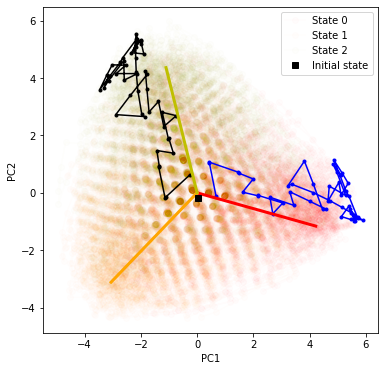

In [ ]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

plt.figure(figsize=(6, 6))

pc1 = 0
pc2 = 1

# state_labels = ['Positive examples', 'Negative examples']
state_labels = ['State {}'.format(i) for i in range(len(toy_params['sentiments']))]
state_colors = ['r', 'orange', 'y', 'g', 'b', 'm']
for i in range(len(toy_params['sentiments'])):
  pca_states = pca_full.transform(np.vstack(states[i])).T
  plt.plot(pca_states[pc1], pca_states[pc2], c = state_colors[i], marker='o', alpha=0.01, label=state_labels[i])

plt.plot(pca_path[:,pc1], pca_path[:,pc2], c='k', marker='.')
plt.plot(rot_pca_path[:,pc1], rot_pca_path[:,pc2], c='b', marker='.')

# Plots readout direction
for i in range(len(readout)):
  ro_dir = np.matmul(comp, readout[i])
  x_ro = [0, ro_dir[pc1]]
  y_ro = [0, ro_dir[pc2]]
  plt.plot(x_ro, y_ro, state_colors[i], linewidth = 3)

pca_h0 = pca.transform(np.atleast_2d(h0)).T
plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1+1))
plt.ylabel('PC'+str(pc2+1))
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

plt.legend()

#### Network Flow

In [ ]:
# Shows flow of network at various locations in hidden-state space
add_noise = False
noise_scale = 0.01
cell_type = 'enc'

# flow_points_raw = fixed_points
flow_points_raw = hs_grid_points[:,:rnn_specs['hidden_size']]
# flow_points_raw = np.copy(pts)
if add_noise:
  flow_points_raw += np.random.normal(loc=0.0, scale=noise_scale, size=flow_points_raw.shape)

word = 'I0' #['O0', 'O1', 'O2']
if word == None:
  word_tensor = jnp.zeros(rnn_specs['input_size'])
elif cell_type == 'enc':
  word_tensor = wordToTensor(word, toy_params['in_words'])[0]
elif cell_type == 'dec':
  word_tensor = wordToTensor(word, toy_params['out_words'])[0]

# word_tensor = np.asarray([wordToTensor('not', toy_params['words'])[0], wordToTensor('very0', toy_params['words'])[0]])

# Filters out non-unique points
unique_tol = 0.5
do_print = True
points_unique, unique_kidxs = keep_unique_fixed_points(flow_points_raw, unique_tol, do_print)
steps = 1

points_reduced = points_unique #[::18]
points_final_pca = np.zeros((len(points_reduced), pc_dims))
# print(points_reduced.shape)
points_init_pca = pca.transform(np.vstack(points_reduced))
if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']: # add zeros to hidden state
    null_hs = np.zeros(points_reduced.shape)
    points_reduced = np.concatenate((points_reduced, null_hs), axis=1)
for pt_idx in range(len(points_reduced)):
  ref_point = points_reduced[pt_idx]
  for step in range(steps):
    if rnn_specs['arch'] == 'enc_dec' and cell_type == 'dec':
      def_state = cell_dec.apply(rnn_params_dec, word_tensor, ref_point)
    else:
      def_state = cell.apply(rnn_params, word_tensor, ref_point)
    ref_point = def_state
  points_final_pca[pt_idx] = pca.transform(np.atleast_2d(def_state[:rnn_specs['hidden_size']]))[0]
  
print(points_init_pca.shape)
print(points_final_pca.shape)

    Kept 840/840 unique fixed points with uniqueness tolerance 0.500000.
(840, 10)
(840, 10)


Text(0, 0.5, 'PC1')

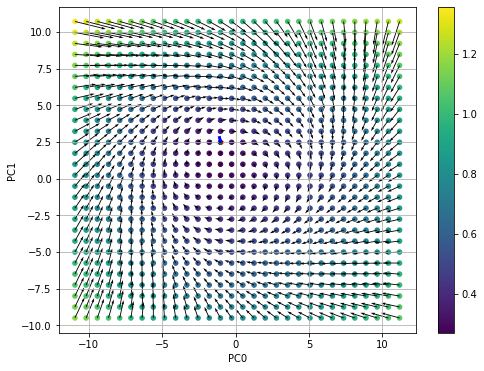

In [ ]:
plt.figure(figsize=(8, 6))

pc1 = 0
pc2 = 1

# pca_fps = pca.transform(np.vstack(fixed_points)).T
pca_fps = pca.transform(np.vstack(hs_grid_points[:,:rnn_specs['hidden_size']])).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
# plt.pcolormesh(pca_fps[pc1].reshape(30, 26), pca_fps[pc2].reshape(30, 26), np.log10(fp_losses.reshape(30, 26)))
plt.grid()

plt.colorbar()

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label='RO'+str(i))

plt.quiver(points_init_pca[:,pc1], points_init_pca[:,pc2], points_final_pca[:,pc1]-points_init_pca[:,pc1], 
           points_final_pca[:,pc2]-points_init_pca[:,pc2], units='xy', scale=3)

plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))

In [ ]:
pc1 = 0
pc2 = 1

deflection_mags = np.zeros((points_init_pca.shape[0]))
counter = 0
for fp_init, fp_final, idx in zip(points_init_pca, points_final_pca, range(points_init_pca.shape[0])):
  deflection = np.asarray([fp_final[pc1] - fp_init[pc1], fp_final[pc2] - fp_init[pc2]])
  deflection_mags[idx] = np.linalg.norm(deflection)

print(np.max(deflection_mags))
print(np.min(deflection_mags))
deflection_mags.sort()

plt.plot(deflection_mags)